In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, nbinom
import scipy.stats as stats
from scipy.special import gamma, factorial
import scipy # Import the top-level scipy module
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# 코렙 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (19.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and direc

#  웨이퍼 결함 분포 모델링

## 결함수

In [ ]:
# 1. 결함 밀도 관련
alpha = 4.2             # 클러스터 파라미터
lambda_defect = 0.035   # defects/cm^2
A = 706.9               # Wafer Area
cutoff_defect = 71      # 불량 기준

# 2. 평탄도 관련
mu_flat = 2.11004       # 평균
sigma_flat = 0.78286    # 표준편차 (변경된 값 적용)
usl_flat = 3.5          # 규격 상한 (USL)


[1] 결함 수 (Defect Count) 분석
▶ 결함 불량 확률 (P_defect): 0.004739 (0.47%)


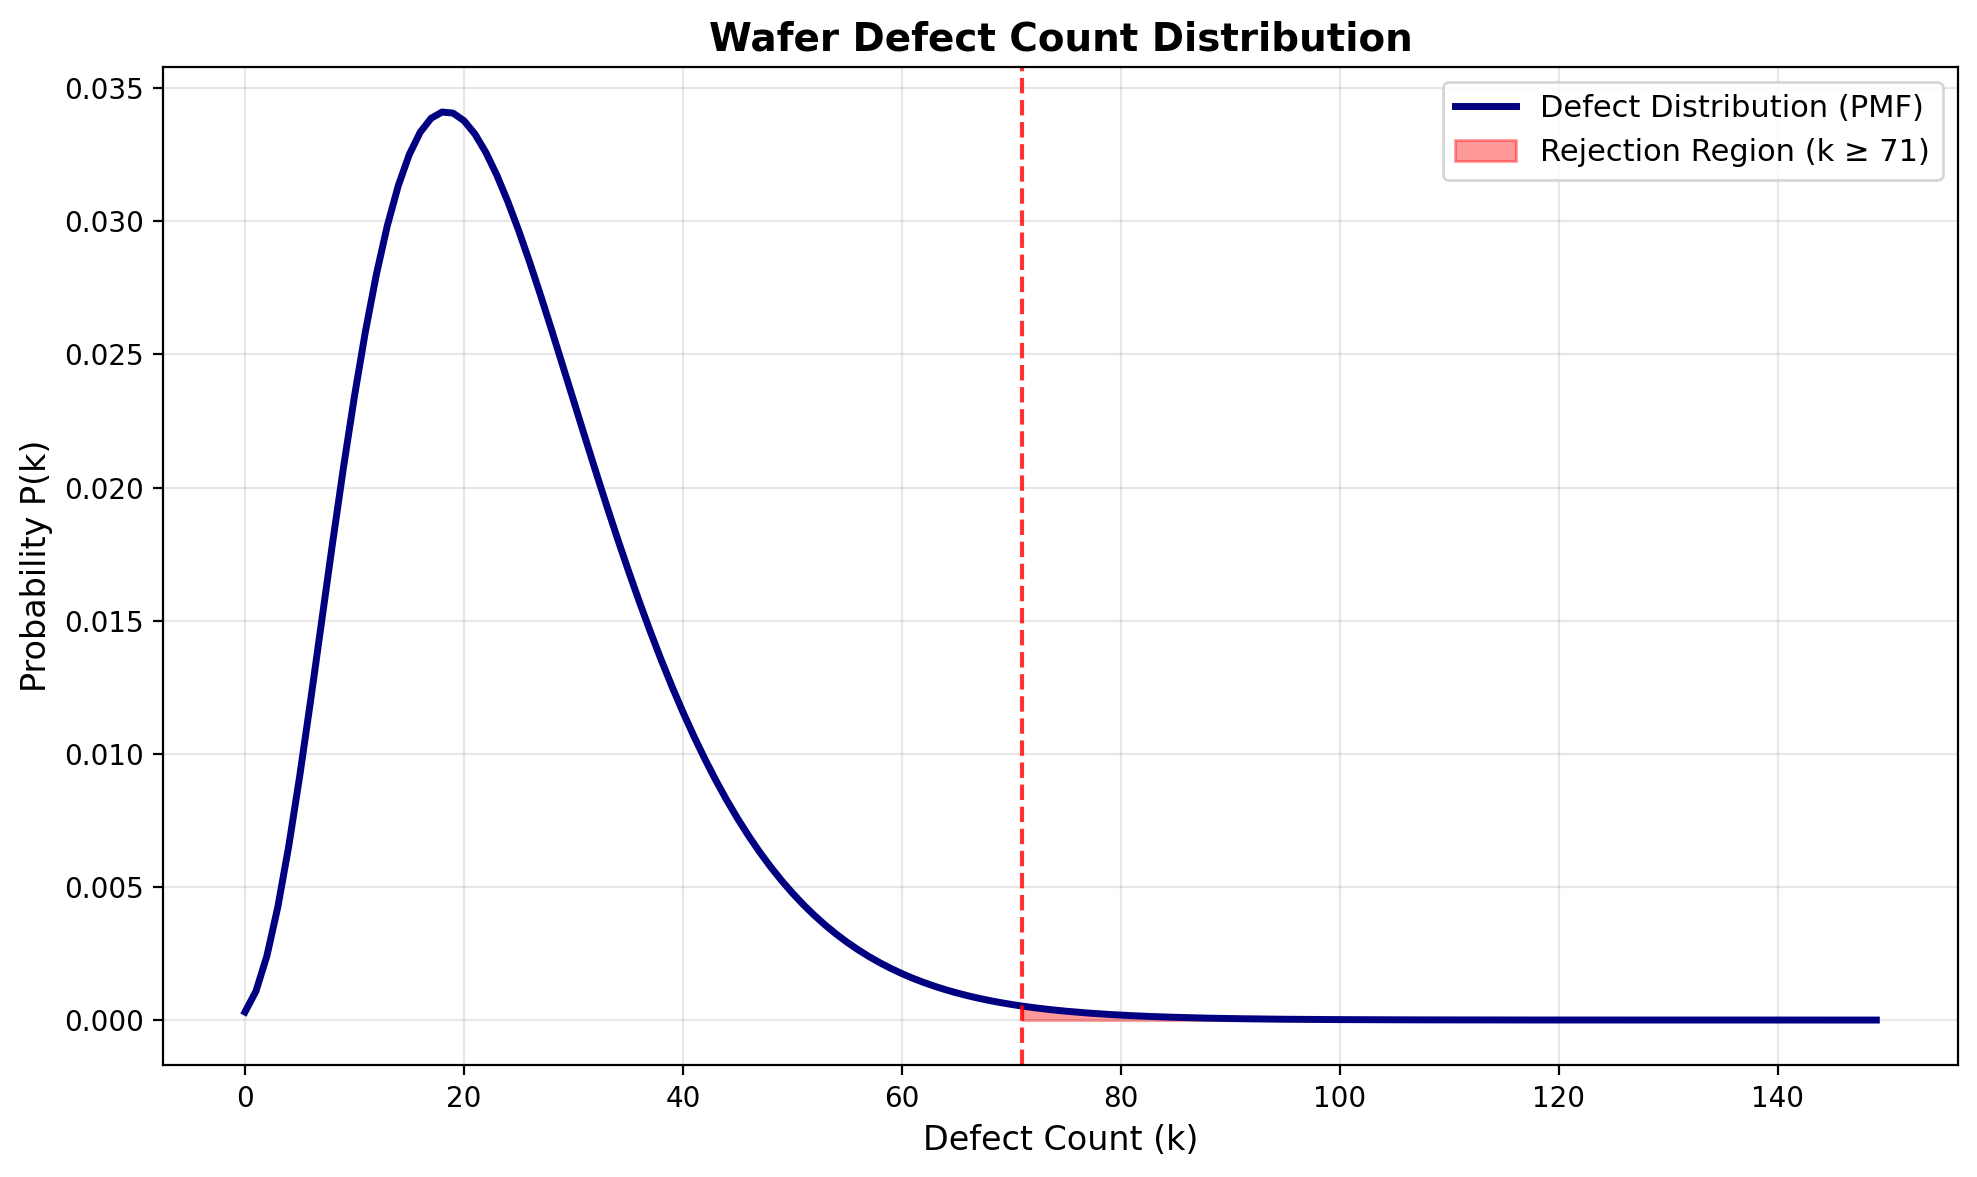

In [ ]:
# ==========================================
# [1] 결함 수 (Defect Count) 분석
# ==========================================
print("\n" + "="*50)
print("[1] 결함 수 (Defect Count) 분석")
print("="*50)

# 1-1. 음이항 분포 PMF 계산 함수
def negbinom_pmf(k, alpha, lambda_defect, A):
    mu = lambda_defect * A
    term1 = gamma(k + alpha) / (gamma(alpha) * factorial(k))
    term2 = (mu / (alpha + mu))**k
    term3 = (alpha / (alpha + mu))**alpha
    return term1 * term2 * term3

# 1-2. 데이터 생성 및 확률 계산
k_values = np.arange(0, 150)
pmf_defect = np.array([negbinom_pmf(k, alpha, lambda_defect, A) for k in k_values])

# 결함 불량 확률 (P_defect)
p_defect = pmf_defect[k_values >= cutoff_defect].sum()
print(f"▶ 결함 불량 확률 (P_defect): {p_defect:.6f} ({p_defect*100:.2f}%)")

# 1-3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_values, pmf_defect, color='navy', linewidth=2.5, label='Defect Distribution (PMF)')
plt.fill_between(k_values, pmf_defect, where=(k_values >= cutoff_defect),
                 color='red', alpha=0.4, label=f'Rejection Region (k ≥ {cutoff_defect})')

plt.title(f"Wafer Defect Count Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Defect Count (k)", fontsize=12)
plt.ylabel("Probability P(k)", fontsize=12)
plt.axvline(x=cutoff_defect, color='red', linestyle='--', alpha=0.8)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 평탄도 TTV
---
* 분포: $N(\mu=2.11004, \sigma=0.78286)$
* 규격(USL): $3.5$ (이 값을 초과하면 불량)


[2] 평탄도 (Flatness) 분석
▶ 평탄도 불량 확률 (P_flat): 0.037909 (3.79%)


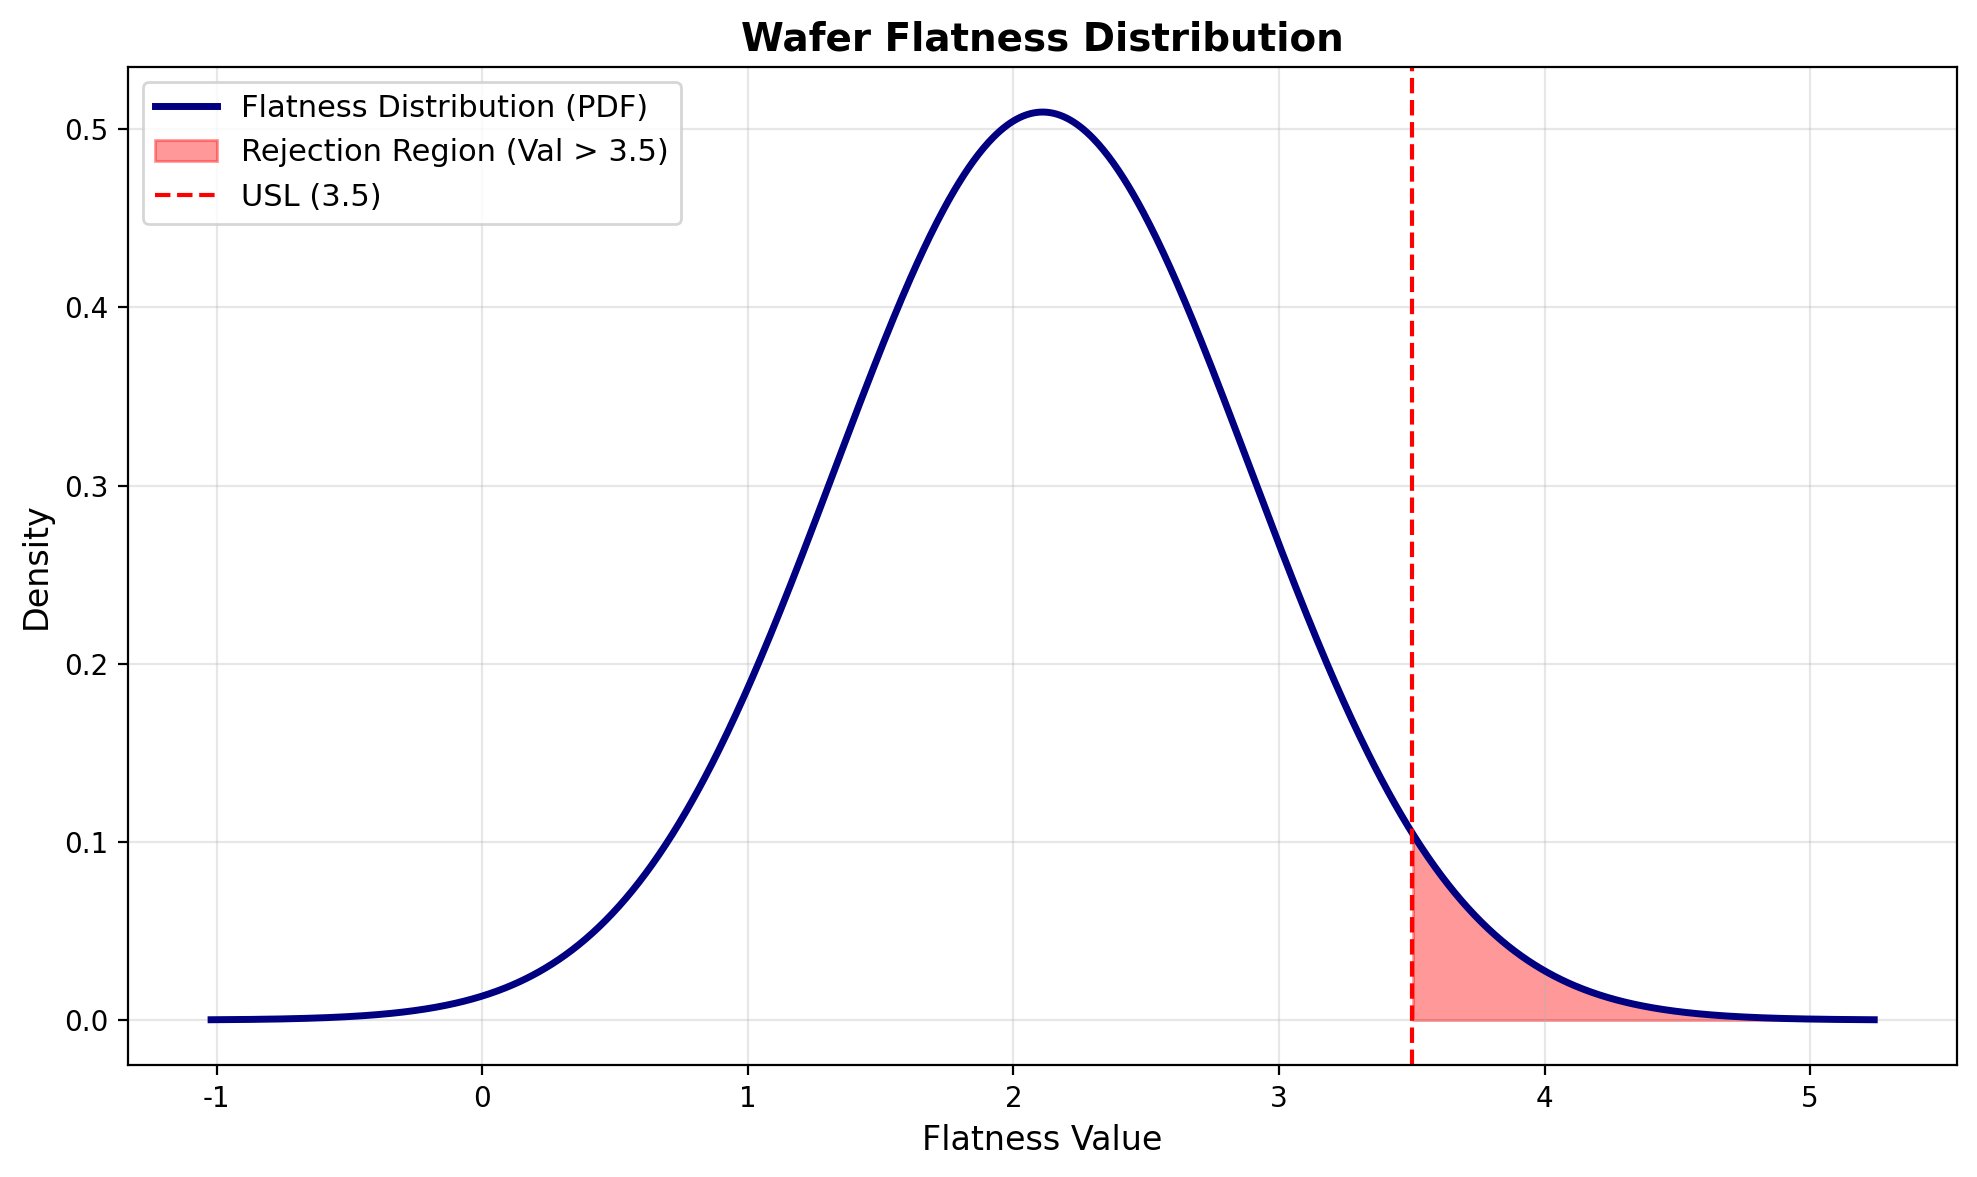

In [ ]:
# ==========================================
# [2] 평탄도 (Flatness) 분석
# ==========================================
print("\n" + "="*50)
print("[2] 평탄도 (Flatness) 분석")
print("="*50)

# 2-1. 평탄도 불량 확률 계산 (정규분포)
# P_flat = 1 - CDF(USL)
p_flat = 1 - stats.norm.cdf(usl_flat, loc=mu_flat, scale=sigma_flat)
print(f"▶ 평탄도 불량 확률 (P_flat): {p_flat:.6f} ({p_flat*100:.2f}%)")

# 2-2. 시각화
x_flat = np.linspace(mu_flat - 4*sigma_flat, mu_flat + 4*sigma_flat, 1000)
pdf_flat = stats.norm.pdf(x_flat, loc=mu_flat, scale=sigma_flat)

plt.figure(figsize=(10, 6))
plt.plot(x_flat, pdf_flat, color='navy', linewidth=2.5, label='Flatness Distribution (PDF)')
plt.fill_between(x_flat, pdf_flat, where=(x_flat > usl_flat),
                 color='red', alpha=0.4, label=f'Rejection Region (Val > {usl_flat})')

plt.title(f"Wafer Flatness Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Flatness Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(x=usl_flat, color='red', linestyle='--', label=f'USL ({usl_flat})')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 웨이퍼 불량 확률
---
$$P_{total} = 1 - (\text{결함 양품 확률} \times \text{평판도 양품 확률})$$$$P_{total} = 1 - \{ (1 - P_{defect}) \times (1 - P_{flat}) \}$$

In [ ]:
# ==========================================
# [3] 최종 웨이퍼 불량 확률 도출
# ==========================================
print("\n" + "="*50)
print("[3] 최종 웨이퍼 불량 확률 (Total Failure Probability)")
print("="*50)

# 3-1. 독립 사건 가정하에 합집합 확률 계산
# P_total = 1 - (결함 양품 확률 * 평탄도 양품 확률)
p_total = 1 - (1 - p_defect) * (1 - p_flat)

print(f"▶ 공식: P_total = 1 - (1 - P_defect) * (1 - P_flat)")
print(f"▶ 계산: 1 - (1 - {p_defect:.6f}) * (1 - {p_flat:.6f})")
print("-" * 50)
print(f"▶ 최종 결과 (P_total): {p_total:.6f} ({p_total*100:.2f}%)")
print("="*50)


[3] 최종 웨이퍼 불량 확률 (Total Failure Probability)
▶ 공식: P_total = 1 - (1 - P_defect) * (1 - P_flat)
▶ 계산: 1 - (1 - 0.004739) * (1 - 0.037909)
--------------------------------------------------
▶ 최종 결과 (P_total): 0.042468 (4.25%)


# 로트 통과 확률 모델링 (이항 분포)

입고된 웨이퍼는 **AQL 샘플링 검사**를 통해 로트 단위로 합격 여부가 판정됩니다.

검사 정확도 (Averroes AI AOI 기준):

| 구분 | 기호 | 값 | 의미 |  |
| --- | --- | --- | --- | --- |
| 오탐지율 | $\alpha_{\text{test}}$ | 0.01 | 정상 → 불량으로 오판 |  |
| 불량 탐지율 | $1-\beta_{\text{test}}$ | 0.98 | 불량을 정확히 탐지 |  |

샘플 1개의 불량 판정 확률:

$$
p' = (1-p)\,\alpha_{\text{test}} + p\,(1-\beta_{\text{test}})
$$

▶ 적용된 진짜 불량률 (p_bad) : 4.25%
▶ 샘플 1개 불량 판정 확률 (p') : 0.05122 (5.12%)
----------------------------------------
✅ 로트 통과 확률 (P_accept) : 0.7688 (76.88%)
❌ 로트 거부 확률 (P_reject) : 0.2312 (23.12%)
----------------------------------------


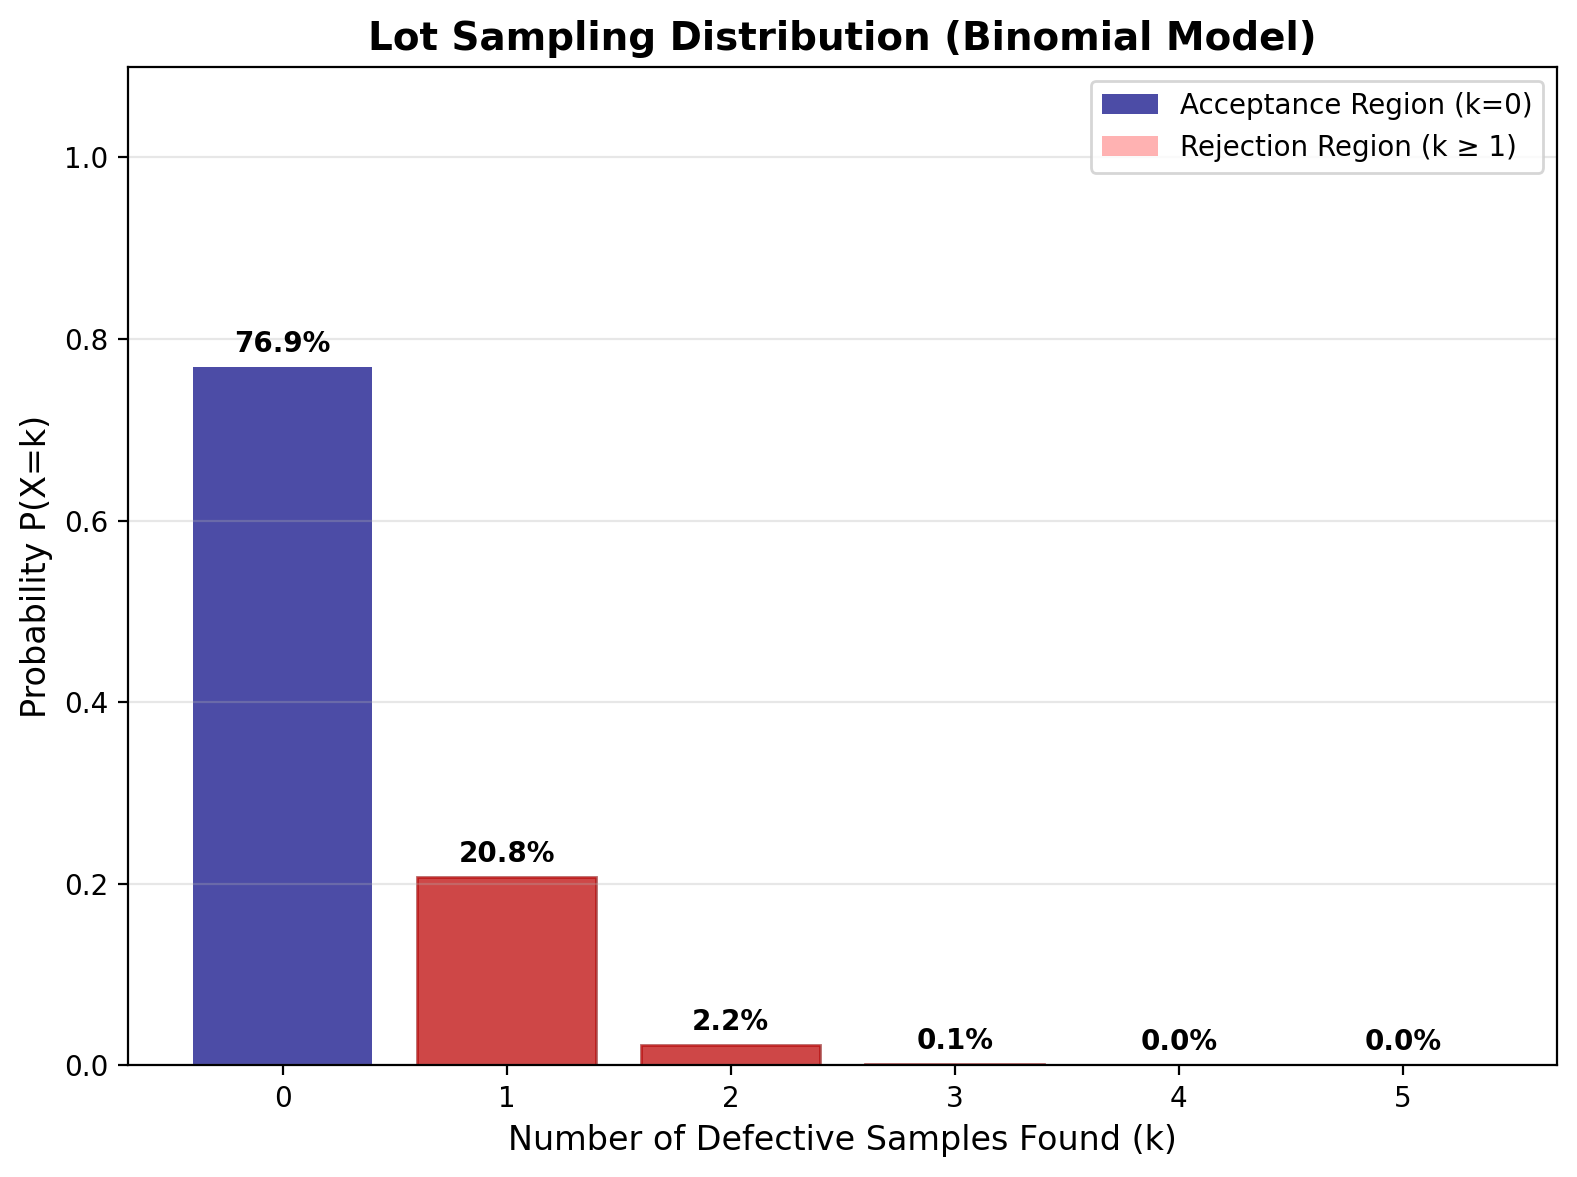

In [ ]:
from scipy.stats import binom

# ==========================================
# 1. 파라미터 설정 (Updated Context)
# ==========================================
# p_bad: 결함 밀도(0.47%)와 평탄도(3.79%)를 통합한 '진짜 불량 확률'
p_bad = 0.0425        # P_total 값 적용

alpha_test = 0.01     # 오탐지율 (False Positive) -> 1%로 개선 가정
beta_test = 0.02      # 누락률 (False Negative)
n_sample = 5          # 샘플 크기 (AQL Level II)
lot_size = 25         # 로트 크기

# ==========================================
# 2. 검사 정확도 반영 (p' 계산)
# ==========================================
# p_prime: 샘플 1개가 '불량'으로 판정될 확률
# = (양품인데 오탐지될 확률) + (불량인데 정탐지될 확률)
p_prime = (1 - p_bad) * alpha_test + p_bad * (1 - beta_test)

print(f"▶ 적용된 진짜 불량률 (p_bad) : {p_bad*100:.2f}%")
print(f"▶ 샘플 1개 불량 판정 확률 (p') : {p_prime:.5f} ({p_prime*100:.2f}%)")

# ==========================================
# 3. 로트 합격/거부 확률 (이항분포 모델링)
# ==========================================
# X: 샘플 5개 중 발견된 불량 판정 수 ~ Binomial(n=5, p=p')
# 합격 기준: X = 0 (불량이 하나도 없어야 함)

P_accept = binom.cdf(0, n_sample, p_prime)   # P(X=0)
P_reject = 1 - P_accept                      # P(X>=1)

print("-" * 40)
print(f"✅ 로트 통과 확률 (P_accept) : {P_accept:.4f} ({P_accept*100:.2f}%)")
print(f"❌ 로트 거부 확률 (P_reject) : {P_reject:.4f} ({P_reject*100:.2f}%)")
print("-" * 40)

# ==========================================
# 4. 이항분포 PMF 시각화
# ==========================================
k_values = np.arange(0, n_sample + 1)
pmf_values = binom.pmf(k_values, n_sample, p_prime)

plt.figure(figsize=(8, 6))

# Bar Chart: 전체 확률 분포
bars = plt.bar(k_values, pmf_values, color='navy', alpha=0.7, label='Acceptance Region (k=0)')

# Rejection Region (k >= 1) 강조 (빨간색)
for i in range(1, len(k_values)):
    bars[i].set_color('darkred')
    bars[i].set_alpha(0.6)

# 범례용 더미 플롯 (빨간색 바)
plt.bar(k_values[k_values >= 1], pmf_values[k_values >= 1],
        color='red', alpha=0.3, label='Rejection Region (k ≥ 1)')

# 그래프 데코레이션
plt.title(f"Lot Sampling Distribution (Binomial Model)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Defective Samples Found (k)", fontsize=12)
plt.ylabel("Probability P(X=k)", fontsize=12)
plt.xticks(k_values)
plt.ylim(0, 1.1)  # Y축 여백 확보

# 막대 위에 수치 표시
for k, prob in zip(k_values, pmf_values):
    plt.text(k, prob + 0.01, f"{prob:.1%}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 품질 비용 매핑

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import binom

# ==========================================
# 1. 파라미터 설정 (Parameters)
# ==========================================
# 통합 불량 확률 (P_total) = 결함(0.47%) + 평탄도(3.79%)
p = 0.0425

# 검사 장비 성능
alpha_test = 0.01   # 오탐지율 (Type I Error)
beta_test = 0.02    # 누락률 (Type II Error)

# 로트 및 샘플링 정보
lot_size = 25
n_sample = 5

# [cite_start]비용 단가 (USD) - 보고서 기준 [cite: 167]
C_opportunity = 2500   # 기회비용 (정상품 폐기)
C_scrap = 900          # 폐기비용 (불량품 폐기)
C_bad_ship = 17100     # 불량 출하 비용
C_inspect = 30         # 검사비용

# ==========================================
# 2. 검사 확률 및 수량 계산 (Calculation)
# ==========================================
# [1] 샘플 1개가 '불량'으로 판정될 확률 (p')
# 양품인데 오탐지 + 불량인데 정탐지
p_prime = (1 - p) * alpha_test + p * (1 - beta_test)

# [2] 로트 합격/거부 확률 (AQL c=0 기준)
P_accept = binom.cdf(0, n_sample, p_prime) # 합격 확률
P_reject = 1 - P_accept                    # 거부 확률

# [3] 로트 내 기대 수량 (Expected Quantities)
E_good = (1 - p) * lot_size  # 로트 당 정상 웨이퍼 수
E_bad = p * lot_size         # 로트 당 불량 웨이퍼 수

# ==========================================
# 3. 실제 비용 발생 시나리오 매핑 (Realistic Logic)
# ==========================================

# 시나리오 A: 로트 거부 (Lot Rejected) -> 전량 폐기
# 거부된 로트 안에 들어있는 '정상 웨이퍼' -> 기회비용
affected_good = P_reject * E_good
# 거부된 로트 안에 들어있는 '불량 웨이퍼' -> 폐기비용
affected_bad = P_reject * E_bad

# 시나리오 B: 로트 합격 (Lot Accepted) -> 전량 출하
# 로트가 합격하면, 로트 내의 '불량 웨이퍼(E_bad)'는 전량 출하됨.
# (검사하지 않은 20개에 포함된 불량 + 검사했으나 놓친 불량 모두 포함)
shipped_bad = P_accept * E_bad

# ==========================================
# 4. 총 비용 집계 및 출력
# ==========================================
expected_costs = {
    "기회비용": affected_good * C_opportunity,
    "폐기비용": affected_bad * C_scrap,
    "불량출하비용": shipped_bad * C_bad_ship,
    "검사비용": n_sample * C_inspect
}

total_cost = sum(expected_costs.values())

# 결과 DataFrame 생성
df = pd.DataFrame([
    ["기회비용", P_reject, affected_good, C_opportunity, expected_costs["기회비용"]],
    ["폐기비용", P_reject, affected_bad, C_scrap, expected_costs["폐기비용"]],
    ["불량출하비용", P_accept, shipped_bad, C_bad_ship, expected_costs["불량출하비용"]],
    ["검사비용", 1.000, n_sample, C_inspect, expected_costs["검사비용"]],
], columns=["카테고리", "발생확률", "영향수량(장)", "단위비용($)", "기대비용($)"])

# 포맷팅
df["발생확률"] = df["발생확률"].apply(lambda x: f"{x:.4f}")
df["영향수량(장)"] = df["영향수량(장)"].apply(lambda x: f"{x:.4f}")
df["단위비용($)"] = df["단위비용($)"].apply(lambda x: f"{x:,.0f}")
df["기대비용($)"] = df["기대비용($)"].apply(lambda x: f"{x:,.2f}")

print(f"▶ 적용 파라미터: p={p*100:.2f}%, alpha={alpha_test*100:.0f}%")
print(f"▶ 샘플 판정 불량률(p'): {p_prime:.4f}")
print(f"▶ 로트 통과 확률(P_accept): {P_accept:.4f}")
print("-" * 65)
print(df.to_markdown(index=False))
print("-" * 65)
print(f"✅ 로트당 총 기대 품질비용 = ${total_cost:,.2f}")

▶ 적용 파라미터: p=4.25%, alpha=1%
▶ 샘플 판정 불량률(p'): 0.0512
▶ 로트 통과 확률(P_accept): 0.7688
-----------------------------------------------------------------
| 카테고리     |   발생확률 |   영향수량(장) | 단위비용($)   | 기대비용($)   |
|:-------------|-----------:|---------------:|:--------------|:--------------|
| 기회비용     |     0.2312 |         5.5342 | 2,500         | 13,835.58     |
| 폐기비용     |     0.2312 |         0.2456 | 900           | 221.08        |
| 불량출하비용 |     0.7688 |         0.8169 | 17,100        | 13,968.22     |
| 검사비용     |     1      |         5      | 30            | 150.00        |
-----------------------------------------------------------------
✅ 로트당 총 기대 품질비용 = $28,174.88


# EDA

## 결함 수




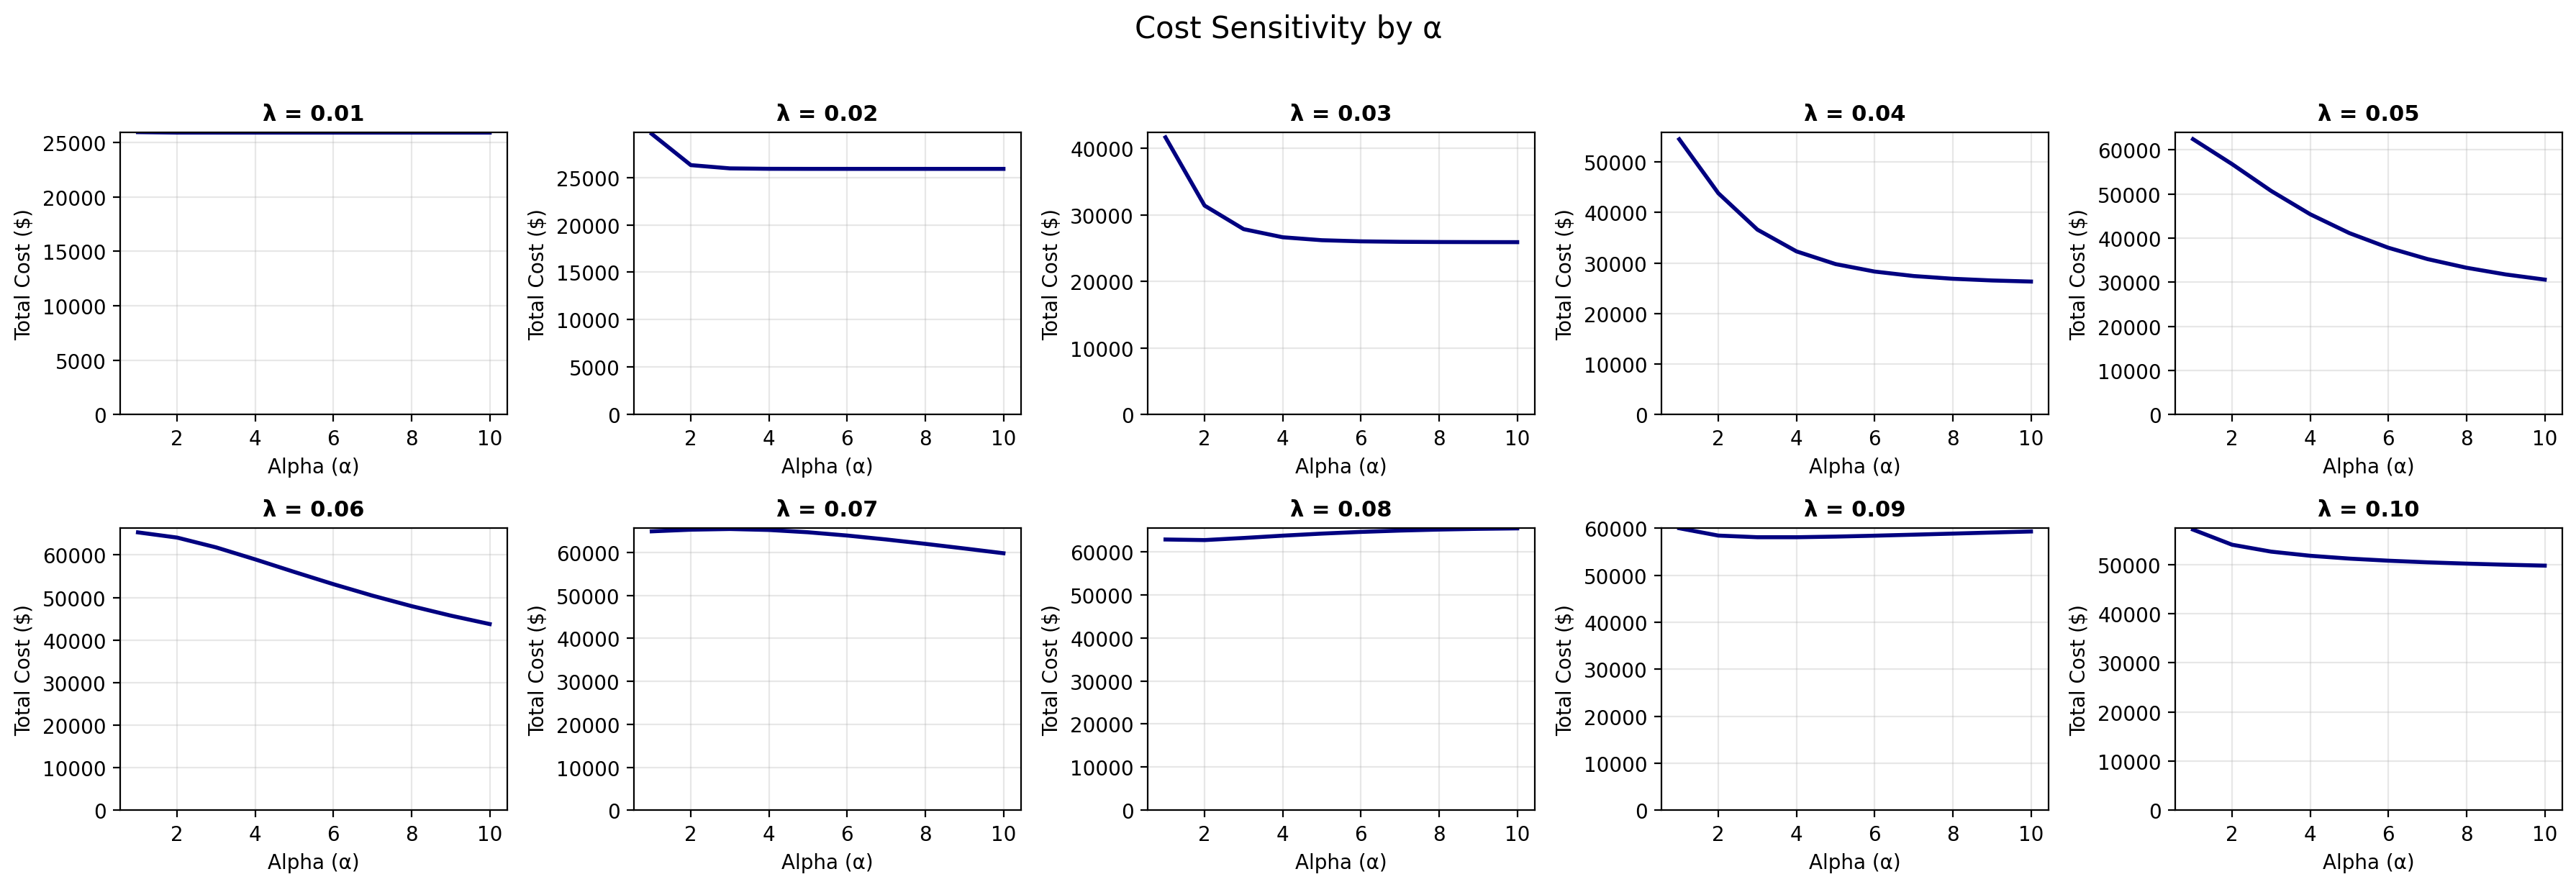

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, binom, norm
from scipy.special import gamma, factorial

# ==========================================
# 1. 기본 파라미터 (평탄도 고정)
# ==========================================
# [공통]
A = 706.9
lot_size = 25
n_sample = 5

# [평탄도 고정 파라미터] -> 베이스 리스크로 작용
MU_FLAT_FIXED = 2.11004
SIGMA_FLAT_FIXED = 0.78286
USL_FLAT = 3.5

# [검사 장비]
alpha_test = 0.01  # 오탐지율 (1%)
beta_test = 0.02   # 누락률 (2%)

# [비용 단가]
C_opportunity = 2500
C_scrap = 900
C_bad_ship = 17100
C_inspect = 30

# ==========================================
# 2. 비용 계산 함수 정의
# ==========================================
def calculate_cost_with_fixed_flatness(lambda_defect, alpha):
    # -------------------------------------------------------
    # 1. 확률 계산
    # -------------------------------------------------------
    # A) 결함 불량 확률 (Negative Binomial)
    # P(X >= 71)
    cutoff = 71
    mu_val = lambda_defect * A
    p_nb = alpha / (alpha + mu_val)
    p_defect = 1 - nbinom.cdf(cutoff - 1, alpha, p_nb)

    # B) 평탄도 불량 확률 (Normal) - 고정값 사용
    # P(X > 3.5)
    p_flat = 1 - norm.cdf(USL_FLAT, loc=MU_FLAT_FIXED, scale=SIGMA_FLAT_FIXED)

    # C) 통합 불량 확률 (독립 사건)
    p_total = 1 - (1 - p_defect) * (1 - p_flat)

    # -------------------------------------------------------
    # 2. 검사 및 비용 매핑 (현실적 일반화 모델 적용)
    # -------------------------------------------------------
    # 샘플 불량 판정 확률
    p_prime = (1 - p_total) * alpha_test + p_total * (1 - beta_test)

    # 로트 판정
    P_accept = binom.cdf(0, n_sample, p_prime)
    P_reject = 1 - P_accept

    # 기대 비용 산출
    # 1) 기회비용: 거부된 로트 속 정상품
    cost_opp = P_reject * (1 - p_total) * lot_size * C_opportunity
    # 2) 폐기비용: 거부된 로트 속 불량품
    cost_scrap = P_reject * p_total * lot_size * C_scrap
    # 3) 불량출하: 합격한 로트 속 불량품 (전량 출하 가정)
    cost_escape = P_accept * (p_total * lot_size) * C_bad_ship
    # 4) 검사비용
    cost_inspect = n_sample * C_inspect

    return cost_opp + cost_scrap + cost_escape + cost_inspect

# ==========================================
# 3. 시각화 데이터 생성
# ==========================================
# 시뮬레이션 그리드
lambda_grid = np.linspace(0.01, 0.10, 10)
alpha_grid = np.linspace(1, 10, 10)

# ==========================================
# 4. (A) λ 고정 → α 변화에 따른 비용 민감도
# ==========================================
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
axes = axes.flatten()

for i, lam in enumerate(lambda_grid):
    costs = [calculate_cost_with_fixed_flatness(lam, a) for a in alpha_grid]

    axes[i].plot(alpha_grid, costs, color='navy', linewidth=2)
    axes[i].set_title(f"λ = {lam:.2f}", fontsize=11, fontweight='bold')
    axes[i].set_xlabel("Alpha (α)")
    axes[i].set_ylabel("Total Cost ($)")
    axes[i].grid(alpha=0.3)

    # Y축 스케일 조정 (비교를 위해)
    axes[i].set_ylim(bottom=0)

plt.suptitle(f"Cost Sensitivity by α", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

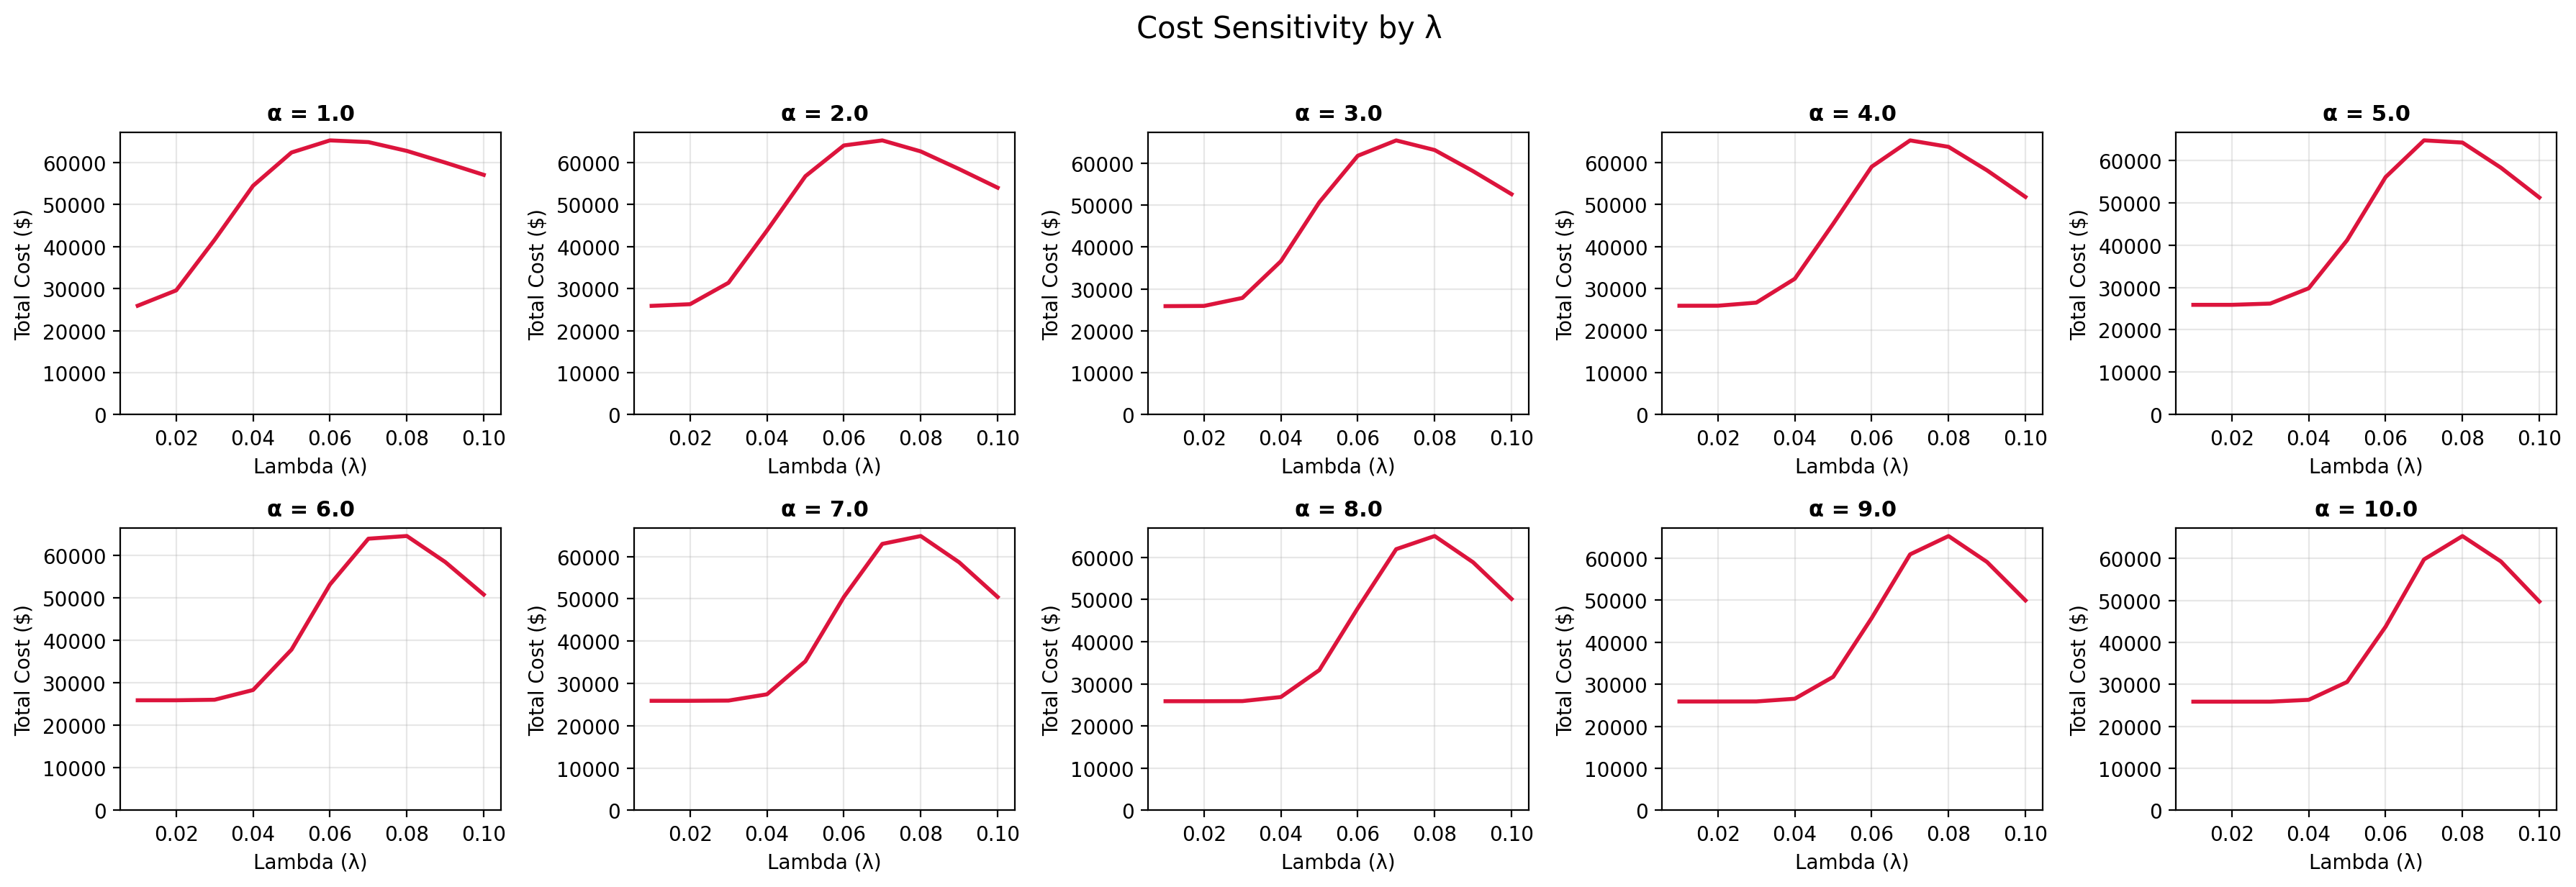

In [ ]:
# ==========================================
# 5. (B) α 고정 → λ 변화에 따른 비용 민감도
# ==========================================
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
axes = axes.flatten()

for i, a in enumerate(alpha_grid):
    costs = [calculate_cost_with_fixed_flatness(l, a) for l in lambda_grid]

    axes[i].plot(lambda_grid, costs, color='crimson', linewidth=2)
    axes[i].set_title(f"α = {a:.1f}", fontsize=11, fontweight='bold')
    axes[i].set_xlabel("Lambda (λ)")
    axes[i].set_ylabel("Total Cost ($)")
    axes[i].grid(alpha=0.3)

    # Y축 스케일 조정
    axes[i].set_ylim(bottom=0)

plt.suptitle(f"Cost Sensitivity by λ", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

### 해석
---

### **1. 비용 민감도 분석: $\alpha$ 고정 조건에서 $\lambda$ 변화 효과 (Image 2)**

이 10개의 서브 플롯은 **클러스터 파라미터($\alpha$)**를 고정했을 때, **결함 밀도($\lambda$)** 증가가 로트당 총 품질 비용에 미치는 영향을 보여줍니다.

* **X축:** $\lambda$ (결함 밀도, $\lambda \uparrow \to$ 불량률 증가)
* **Y축:** 로트당 총 품질 비용 (USD)
* **전제:** 평탄도 불량률(약 3.8%)이 기본 리스크(Base Risk)로 깔려 있어, $\lambda$가 낮아도 비용이 0이 아닌 약 \$26,000에서 시작합니다.

#### **1-1. $\alpha$ 수준별 $\lambda$ 악화 효과 분석**

| $\alpha$ 수준 | 그래프 특징 | 비용 변화 패턴 | 해석 (품질 리스크 민감도) |
| :--- | :--- | :--- | :--- |
| **$\alpha=1.0 \sim 2.0$** (심한 군집) | **초반 급등 후 하락.** $\lambda \approx 0.06$에서 정점을 찍고 꺾임. | $\$26,000 \to \$65,000 \to \$58,000$ | **리스크 조기 포화.** 공정이 불균일하여 $\lambda$가 조금만 올라도 불량 판정률이 치솟습니다. $\lambda > 0.06$에서는 대부분 로트가 거부되어 비용이 오히려 감소하는 패턴을 보입니다. |
| **$\alpha=3.0 \sim 5.0$** (중간 수준) | **전형적인 S자형 상승.** 가파른 상승 구간 존재. | $\$26,000 \to \$65,000$ (Peak) | **표준 민감도.** $\lambda=0.04 \sim 0.07$ 구간(Hot Zone)에서 비용이 가장 급격하게 상승하며, 품질 관리가 가장 중요한 영역입니다. |
| **$\alpha=6.0 \sim 10.0$** (균질 공정) | **완만한 시작 후 급등.** Hot Zone이 우측으로 이동. | 상승 시작점이 $\lambda=0.04$ 이후로 밀림 | **버퍼링 효과.** 공정이 균질할수록 낮은 $\lambda$에서는 비용 상승을 억제하다가, 임계치($\lambda > 0.05$)를 넘어서면 급격히 악화됩니다. |

---

### **2. 비용 민감도 분석: $\lambda$ 고정 조건에서 $\alpha$ 변화 효과 (Image 1)**

이 그래프는 **결함 밀도($\lambda$)** 수준별로 공정 균질화($\alpha$ 증가)가 비용 절감에 얼마나 기여하는지를 보여줍니다.

#### **2-1. $\lambda$ 구간별 $\alpha$ 개선 효과 분석**

| $\lambda$ 구간 | 그래프 특징 | 비용 변화 (USD) | 해석 (α 개선의 한계효용) |
| :--- | :--- | :--- | :--- |
| **$\lambda=0.01 \sim 0.02$** | **수평 유지.** 변화 없음. | $\approx \$26,000$ (고정) | **효과 없음 (Base Cost 지배).** $\lambda$가 낮아도 **평탄도 불량** 때문에 기본 비용이 발생하며, $\alpha$를 개선해도 이 '바닥 비용(Floor Cost)'을 뚫고 내려가지 못합니다. |
| **$\lambda=0.03 \sim 0.04$** | **완만한 하락.** | $\approx \$40,000 \to \$26,000$ | **효과 발생 시작.** 결함 밀도 리스크가 평탄도 리스크 위에 얹어지기 시작하며, $\alpha$ 개선이 이를 상쇄합니다. |
| **$\lambda=0.05 \sim 0.06$** | **급격한 우하향.** 가장 기울기가 큼. | $\approx \$65,000 \to \$45,000$ | **효과 극대 (Target Zone).** 이 구간은 $\alpha$ 개선(공정 균질화)이 총 비용을 가장 드라마틱하게 낮추는 구간입니다. |
| **$\lambda \ge 0.09$** | **높은 수준 유지.** 변화 미미. | $\approx \$60,000 \to \$50,000$ | **효과 한계.** 결함이 너무 많아 $\alpha$가 좋아져도 로트 거부를 막기 어렵습니다. |

---

### **3. 주요 패턴 및 특이점 분석**

#### **1) 평탄도(Flatness)에 의한 바닥 비용 (Floor Cost)**
* 모든 그래프에서 비용의 최저점이 0이 아닌 **약 \$26,000**에서 형성됩니다.
* 이는 $\lambda$가 아무리 좋아도($\approx 0$) 평탄도 불량으로 인해 발생하는 **기회비용 + 불량 출하 비용**이 상수로 작용하기 때문입니다.

#### **2) 고결함 구간($\lambda \ge 0.08$)에서의 비용 감소 현상 (Cost Drop)**
* Image 2를 보면 $\lambda$가 $0.08 \to 0.10$으로 갈수록 총 비용 곡선이 정점을 찍고 내려갑니다. 이는 **직관과 반대되는 현상**처럼 보이지만, 비용 모델 구조상 타당합니다.
#### **3) 결함 밀도가 품질 비용을 지배하는 1차 변수, 알파는 버퍼 역할을 하는 2차 변수**

---

### **[Q&A] 결함 밀도가 0.1로 갈 때 품질 비용이 감소되는가?**

**결론: 네, 감소합니다. (작성하신 논리가 정확합니다)**

이 현상은 **"불량 출하 비용(Escape Cost)의 소멸"** 때문입니다.

1.  **$\lambda$가 극도로 높아지면 ($0.10$):** 실제 불량률 $P_{total}$이 매우 높아집니다.
2.  **로트 거부 확률 ($P_{reject} \to 100\%$):** 샘플 5개 중 하나라도 불량이 나올 확률이 1에 수렴하므로, 거의 모든 로트가 거부됩니다.
3.  **비용 구조의 변화:**
    * **불량 출하 비용 ($\$17,100/wafer$):** 로트가 합격해야 발생하는데, 합격률이 0이 되므로 이 막대한 비용이 **발생하지 않습니다 (0으로 수렴).**
    * **폐기/기회 비용 ($\approx \$2,500/wafer$):** 로트가 전량 폐기되므로 이 비용은 최대치로 발생하지만, 불량 출하 비용보다는 단가가 훨씬 저렴합니다.
4.  **결과:** "비싼 불량 출하"가 사라지고 "상대적으로 싼 전량 폐기"로 비용이 전환되면서, 총 기대 비용은 **수치적으로 감소**하게 됩니다.

> **⚠️ 주의:** 비용 수치상으로는 감소하지만, 이는 **"물건을 하나도 못 파는 상태"**를 의미하므로 경영적으로는 최악의 상황입니다. 따라서 이 감소 구간은 '개선'이 아니라 **'생산 붕괴(Breakdown)'**로 해석해야 합니다.

## 결함 수 3D plot

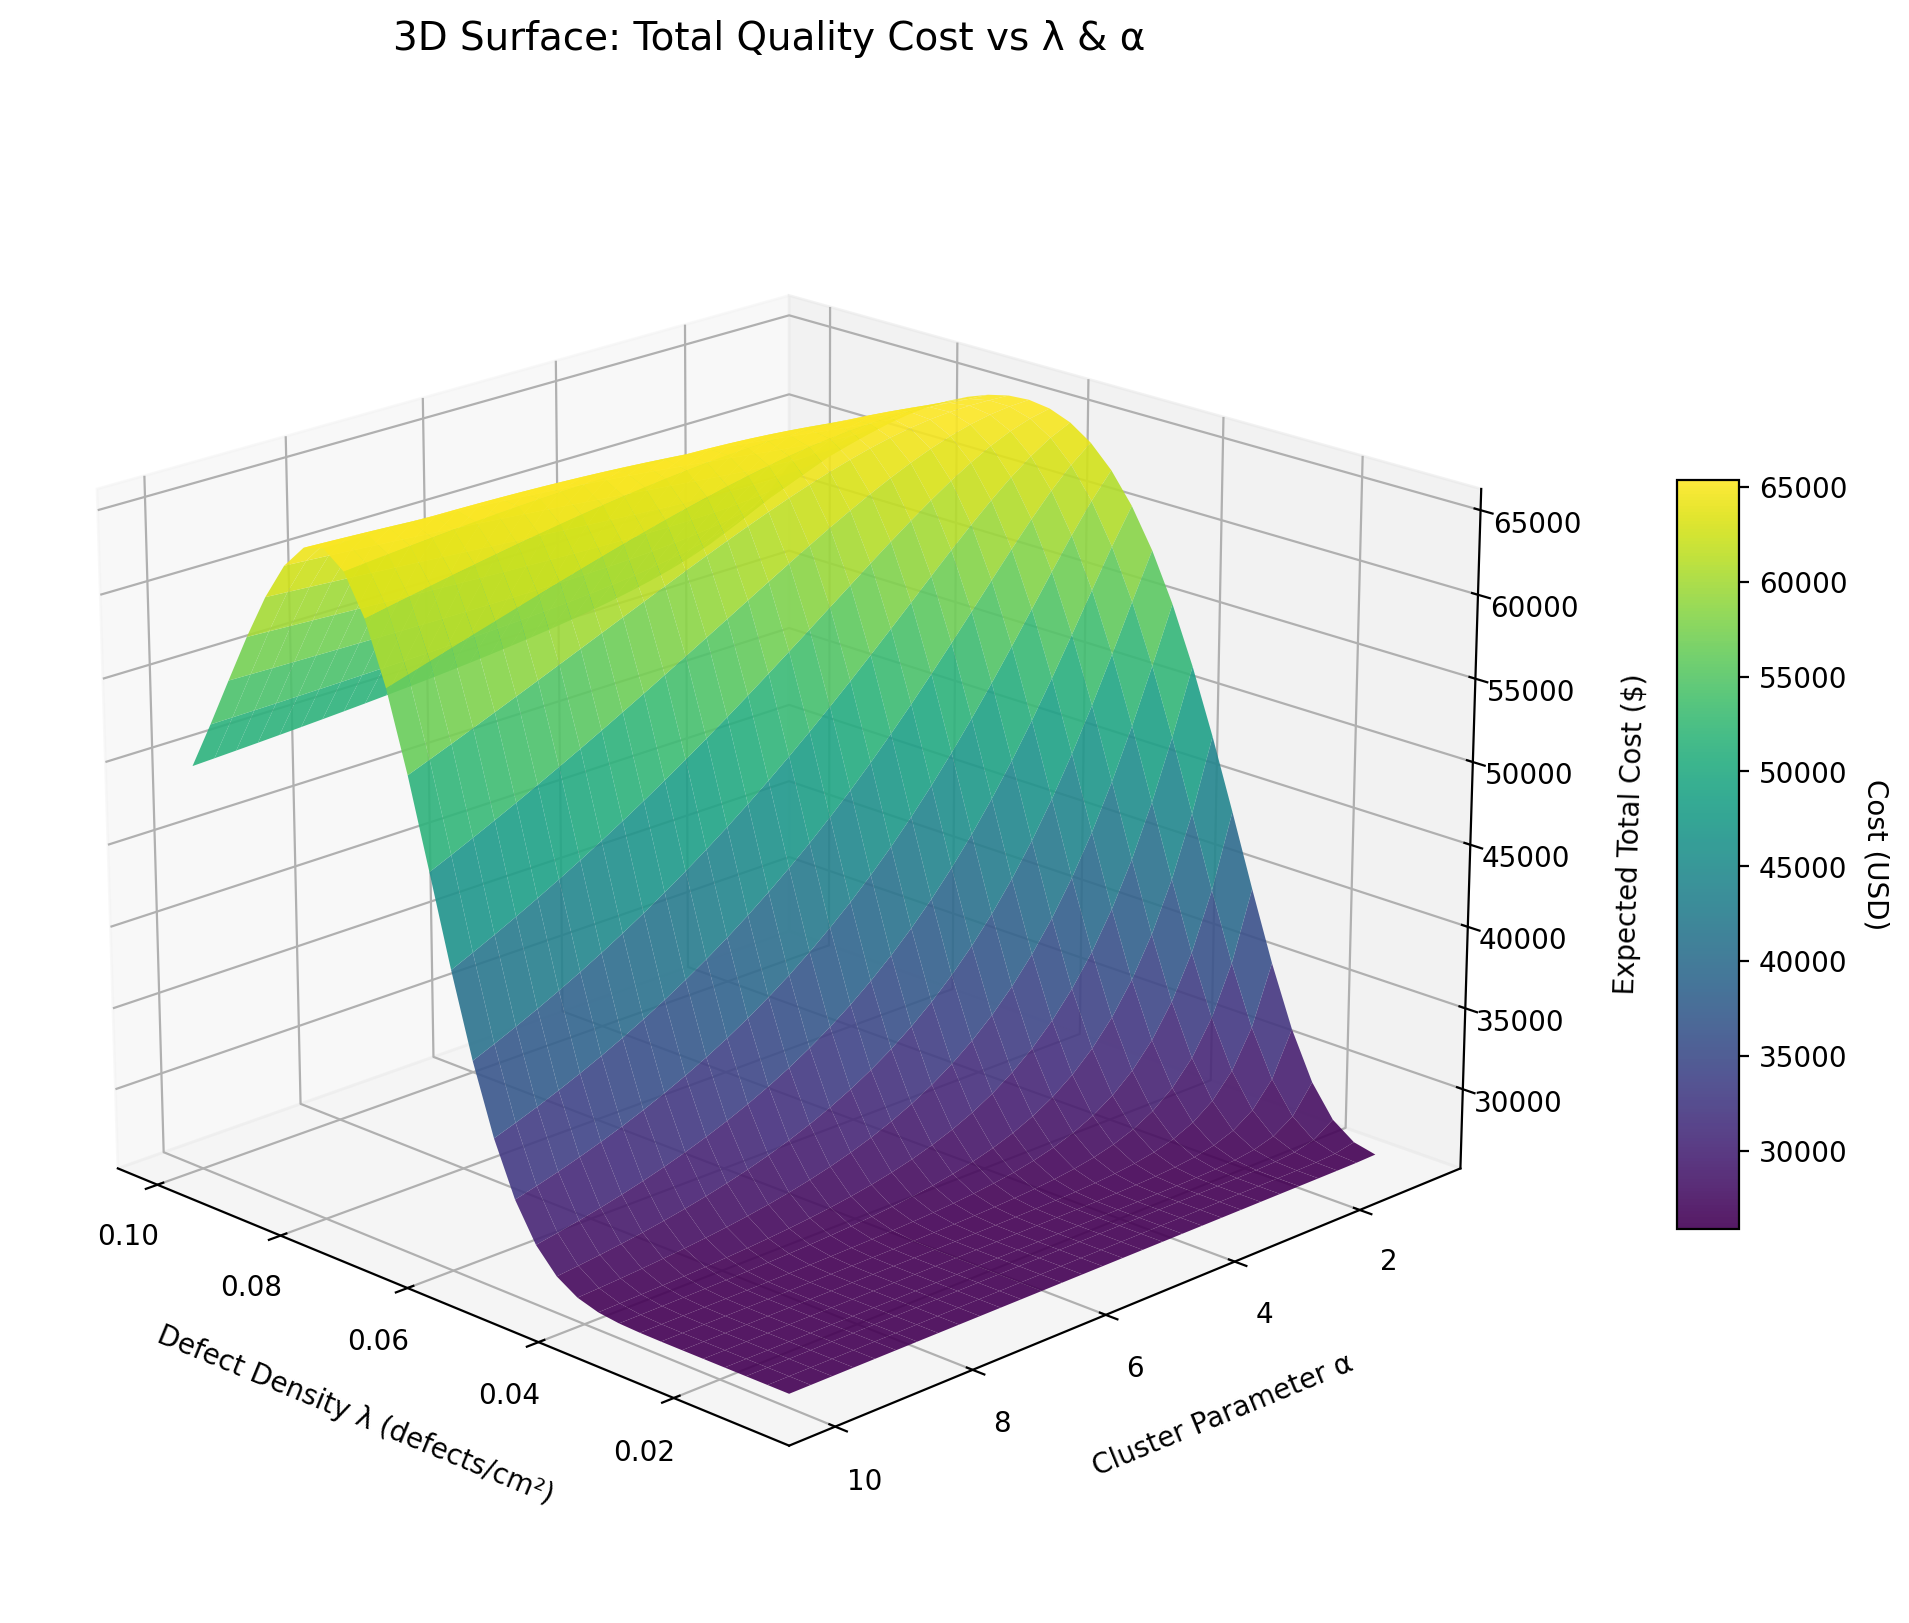

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, binom, norm
from mpl_toolkits.mplot3d import Axes3D

# ==========================================
# 1. 파라미터 및 비용 함수 정의 (Generalized Model)
# ==========================================
# [공통 파라미터]
A = 706.9
lot_size = 25
n_sample = 5

# [평탄도 고정 파라미터]
MU_FLAT_FIXED = 2.11004
SIGMA_FLAT_FIXED = 0.78286
USL_FLAT = 3.5

# [검사 장비]
alpha_test = 0.01   # 오탐지율
beta_test = 0.02    # 누락률

# [비용 단가]
COSTS = {
    'opp': 2500,
    'scrap': 900,
    'escape': 17100,
    'inspect': 30
}

def calculate_total_cost(lambda_d, alpha_d):
    # 1) 결함 불량 확률 (Negative Binomial)
    mu_val = lambda_d * A
    p_nb = alpha_d / (alpha_d + mu_val)
    # P(X >= 71)
    p_defect = 1 - nbinom.cdf(71 - 1, alpha_d, p_nb)

    # 2) 평탄도 불량 확률 (Normal) - 고정값
    p_flat = 1 - norm.cdf(USL_FLAT, loc=MU_FLAT_FIXED, scale=SIGMA_FLAT_FIXED)

    # 3) 통합 불량 확률 (독립 가정)
    p_total = 1 - (1 - p_defect) * (1 - p_flat)

    # 4) 검사 판정 (AQL)
    p_prime = (1 - p_total) * alpha_test + p_total * (1 - beta_test)
    P_accept = binom.cdf(0, n_sample, p_prime)
    P_reject = 1 - P_accept

    # 5) 비용 계산 (현실적 일반화 모델)
    # 불량 출하(Escape) = 합격 확률 * 로트 내 기대 불량 전량(검사 미실시 포함)
    cost = (
        P_reject * (1 - p_total) * lot_size * COSTS['opp'] +
        P_reject * p_total * lot_size * COSTS['scrap'] +
        P_accept * (p_total * lot_size) * COSTS['escape'] +
        n_sample * COSTS['inspect']
    )
    return cost

# ==========================================
# 2. 데이터 생성 (3D Surface용)
# ==========================================
lambda_vals = np.linspace(0.01, 0.10, 30)  # X축: 결함 밀도 (해상도 높임)
alpha_vals = np.linspace(1, 10, 30)        # Y축: 클러스터 파라미터

Lambda, Alpha = np.meshgrid(lambda_vals, alpha_vals)
Cost_surface = np.zeros_like(Lambda)

# 그리드별 비용 계산
for i in range(Lambda.shape[0]):
    for j in range(Lambda.shape[1]):
        Cost_surface[i, j] = calculate_total_cost(Lambda[i, j], Alpha[i, j])

# ==========================================
# 3. 3D Surface Plot
# ==========================================
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Surface Plot
surf = ax.plot_surface(Lambda, Alpha, Cost_surface,
                       cmap='viridis', edgecolor='none', alpha=0.9, antialiased=True)

# 라벨 및 타이틀 설정
ax.set_title("3D Surface: Total Quality Cost vs λ & α", fontsize=14, pad=20)
ax.set_xlabel("Defect Density λ (defects/cm²)", labelpad=12)
ax.set_ylabel("Cluster Parameter α", labelpad=12)
ax.set_zlabel("Expected Total Cost ($)", labelpad=12)

# 컬러바 설정
cbar = fig.colorbar(surf, shrink=0.5, aspect=12, pad=0.1)
cbar.set_label("Cost (USD)", rotation=270, labelpad=15)

# 🔹 시각 각도 설정 (요청하신 각도)
ax.view_init(elev=20, azim=135)

plt.show()

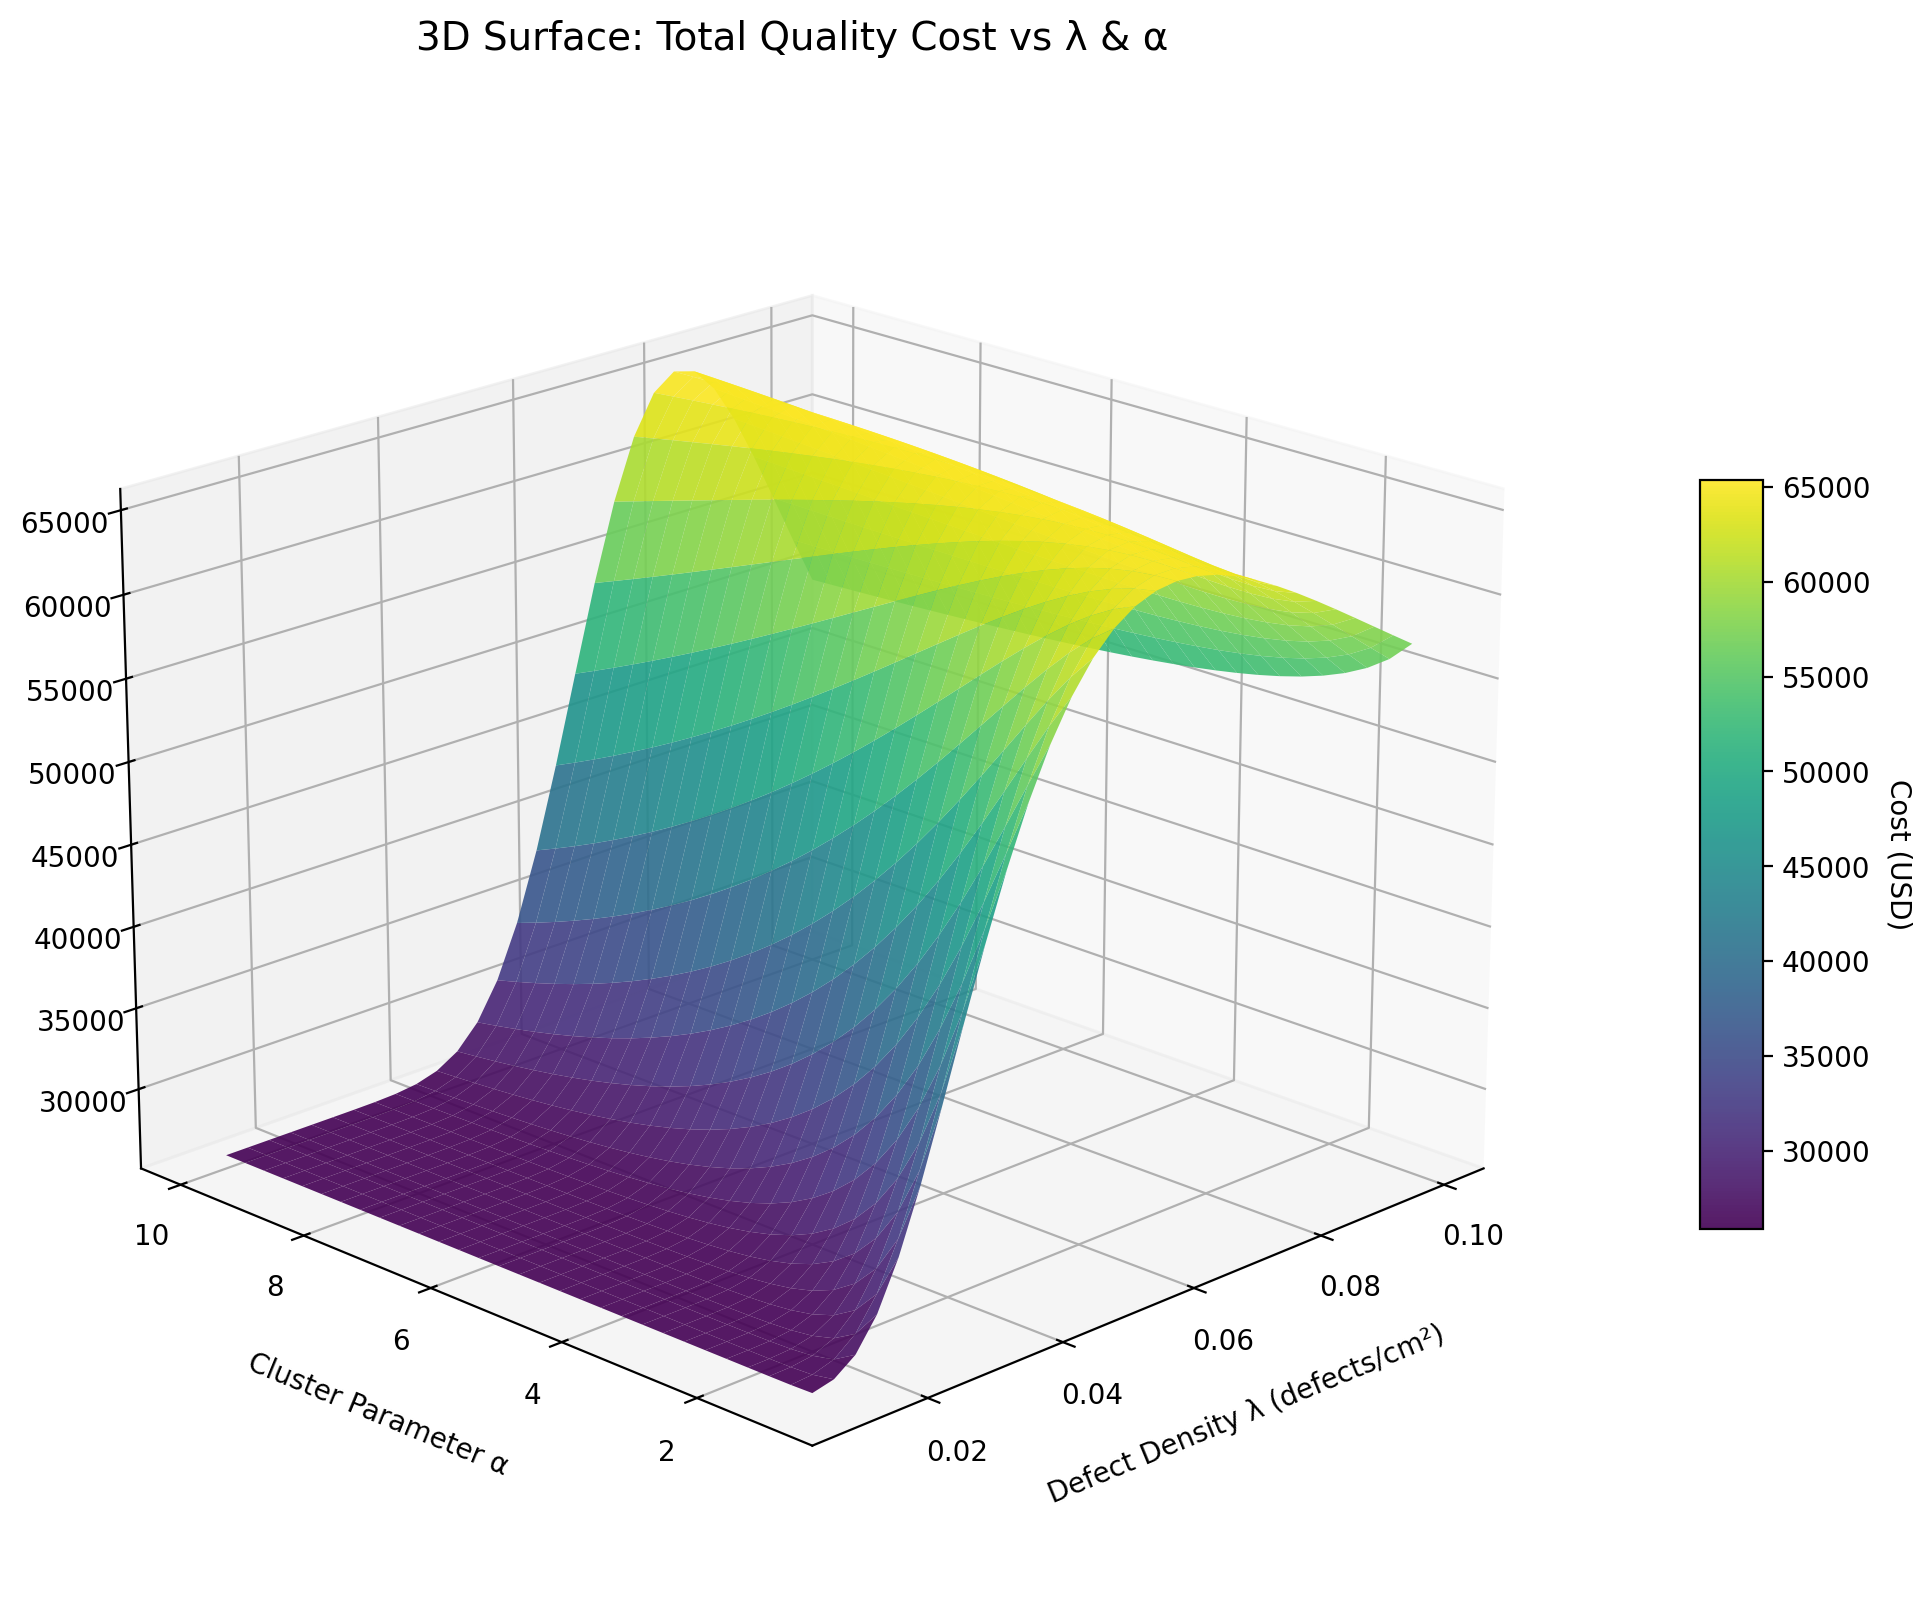

In [ ]:
# ==========================================
# 3. 3D Surface Plot (90도 회전 - azim=225)
# ==========================================
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Surface Plot
surf = ax.plot_surface(Lambda, Alpha, Cost_surface,
                       cmap='viridis', edgecolor='none', alpha=0.9, antialiased=True)

# 라벨 및 타이틀 설정
ax.set_title("3D Surface: Total Quality Cost vs λ & α", fontsize=14, pad=20)
ax.set_xlabel("Defect Density λ (defects/cm²)", labelpad=12)
ax.set_ylabel("Cluster Parameter α", labelpad=12)
ax.set_zlabel("Expected Total Cost ($)", labelpad=12)

# 컬러바 설정
cbar = fig.colorbar(surf, shrink=0.5, aspect=12, pad=0.1)
cbar.set_label("Cost (USD)", rotation=270, labelpad=15)

# 🔹 시각 각도 설정 (기존 135도 + 90도 = 225도)
ax.view_init(elev=20, azim=225)

plt.show()

### 3D 해석
### 3D 곡면 분석: λ & α 상호작용에 따른 총 품질 비용

이 그래프는 평탄도(Flatness) 불량률(≈ 3.8%)이 기본 리스크(Base Risk)로 존재하는 상태에서,  
결함 밀도(λ)와 공정 균질도(α)의 변화가 총 품질 비용에 미치는 복합적인 영향을 3D 곡면으로 시각화한 것이다.

---

## 1. 축의 의미 및 전제 조건

| 축 | 변수 | 설명 |
|---|---|---|
| X축 (λ) | Defect Density | 웨이퍼 단위 면적당 결함 밀도 |
| Y축 (α) | Cluster Parameter | 결함 분포의 균질성 (클수록 균일, 작을수록 군집됨) |
| Z축 (Cost) | Total Quality Cost | 로트당 총 기대 품질비용 (USD) |
| 전제 | Fixed Flatness Risk | 평탄도 불량으로 인한 기본 비용(약 $26,000) 고정 |

---

## 2. 곡면 형태의 핵심 특징

그래프는 오른쪽(λ 증가)으로 갈수록 급등 후 정점을 찍고 완만히 하강하며,  
뒤쪽(α 증가)으로 갈수록 전체 비용이 낮아지는 경향을 보인다.

### λ(Defect Density)의 영향: 급등 후 감소

- 초기 급등 (λ = 0.01 → 0.06):  
  비용이 가장 빠르게 증가하는 구간. 결함 밀도가 평탄도 불량 위에서 임계치를 넘어감.

- 후기 감소 (λ = 0.08 → 0.10):  
  로트 거부율이 매우 높아지면서 불량 출하비용(17,100 USD)이 0으로 수렴.  
  폐기비용(900 USD)만 남아 총 비용이 내려오는 착시.

### α(Cluster Parameter)의 영향: 비용 억제 효과

- α가 클수록 비용 곡면이 낮아짐.  
- 비용이 폭발하기 시작하는 λ의 임계점을 오른쪽으로 미루는 완충 효과 존재.

---





## 평탄도
---
## 평탄도 민감도 분석을 위한 파라미터 범위 설정 (Logic)

본 분석은 평탄도(Flatness) 공정의 핵심 모수인 평균(μ)과 표준편차(σ)가 변화할 때  
총 품질 비용이 어떻게 반응하는지를 분석하기 위한 범위를 설정한 것이다.

범위 설정은 현행(Loose Spec)과 벤치마크(Tight Spec) 간의 차이를  
현재 상태를 중심으로 대칭 확장(symmetric expansion)하는 방식으로 정의한다.

---

## 1. 파라미터 범위 설정 논리

### 평균(μ)의 설정 논리

- 현재 평균: μ = 2.11 μm  
- 벤치마크 평균: μ = 1.21 μm  
- 차이 Δ ≈ 0.9 μm  

→ 벤치마크 값을 최선(Best Case)으로 설정  
→ 동일한 차이만큼 반대쪽으로 확장하여 최악(Worst Case) 설정  
→ 최종 범위: **1.20 ~ 3.00 μm**

---

### 표준편차(σ)의 설정 논리

- 현재 σ = 0.78 μm  
- 벤치마크 σ = 1.23 μm  
- 차이 Δ ≈ 0.45 μm  

→ 벤치마크의 큰 산포를 최악(Worst Case)으로 설정  
→ 동일한 폭 만큼 개선된 값을 최선(Best Case)으로 설정  
→ 최종 범위: **0.30 ~ 1.3 μm**

---

## 2. 정리 표

| 변수 | 현재 수준 | 벤치마크 | 설정 논리 | 최종 분석 범위 |
|------|----------|-----------|------------|----------------|
| 평균(μ) | 2.11 μm | 1.21 μm | 벤치마크를 최소값으로 설정하고 동일폭만큼 상향 확장 | 1.20 ~ 3.00 μm |
| 표준편차(σ) | 0.78 μm | 1.23 μm | 벤치마크의 큰 산포를 최대값으로 설정하고 동일폭만큼 하향 확장 | 0.30 ~ 1.3 μm |

---

## Insight

- 평균(μ): 1.2 (초정밀 공정) ↔ 3.0 μm (USL=3.5 μm 근접 위험 공정)  
- 산포(σ): 0.3 (초균일 공정) ↔ 1.3 μm (불안정 산포 공정)

이 범위를 통해 공정 개선(Shift Left)과 공정 악화(Shift Right) 시나리오를 모두 시각화할 수 있다.


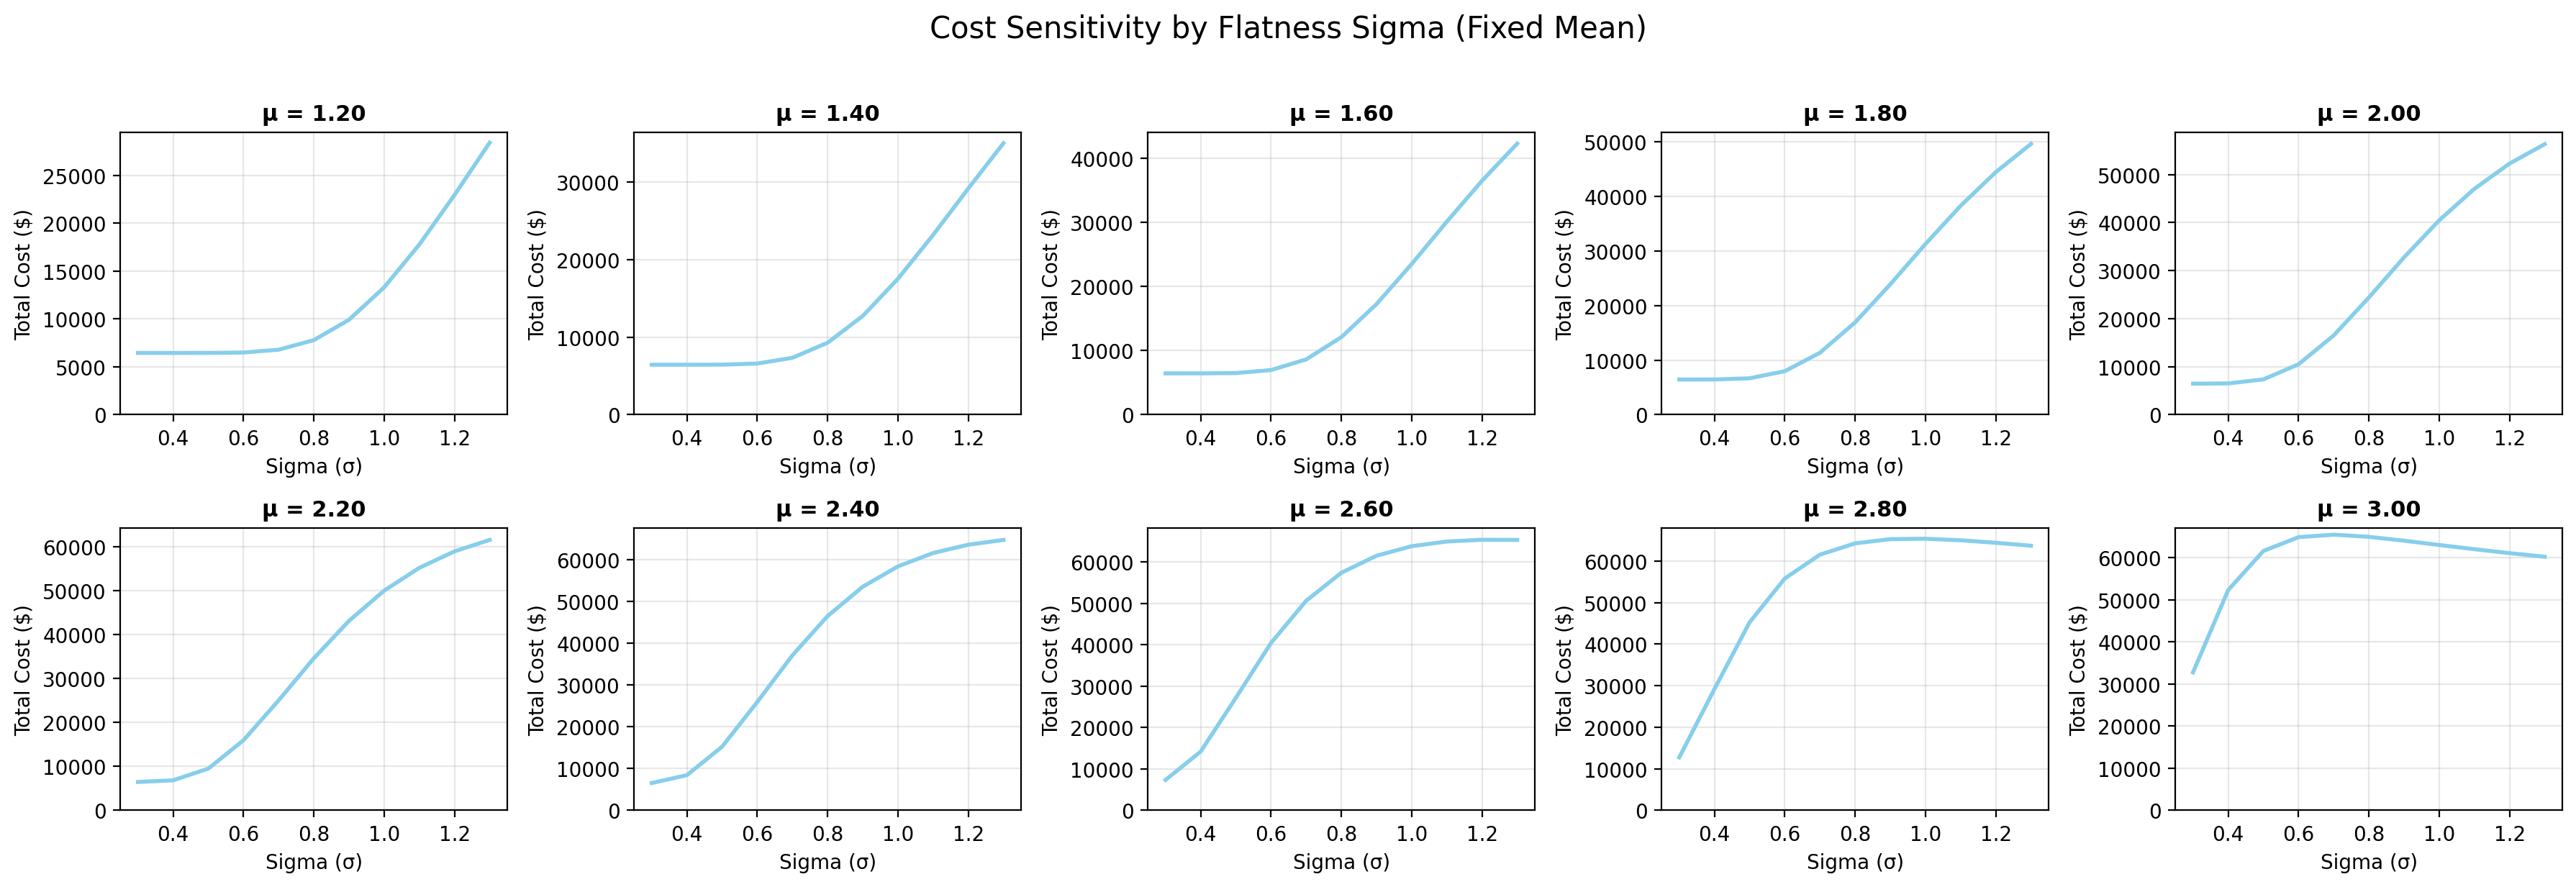

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, binom, norm
from scipy.special import gamma, factorial

# ==========================================
# 1. 기본 파라미터 (결함 밀도 고정, 평탄도 가변)
# ==========================================
# [공통]
A = 706.9
lot_size = 25
n_sample = 5

# [결함 고정 파라미터] -> 베이스 리스크로 작용
LAMBDA_FIXED = 0.035
ALPHA_FIXED = 4.2
CUTOFF = 71

# [검사 장비]
alpha_test = 0.01  # 오탐지율 (1%)
beta_test = 0.02   # 누락률 (2%)

# [비용 단가]
C_opportunity = 2500
C_scrap = 900
C_bad_ship = 17100
C_inspect = 30
USL_FLAT = 3.5

# ==========================================
# 2. 비용 계산 함수 정의 (평탄도 가변)
# ==========================================
def calculate_cost_flatness(mu_f, sigma_f):
    # 1) 결함 불량 확률 (Negative Binomial) - 고정값 사용
    # P(X >= 71)
    mu_val = LAMBDA_FIXED * A
    p_nb = ALPHA_FIXED / (ALPHA_FIXED + mu_val)
    p_defect = 1 - nbinom.cdf(CUTOFF - 1, ALPHA_FIXED, p_nb)

    # 2) 평탄도 불량 확률 (Normal) - 가변 파라미터 사용
    # P(X > 3.5)
    p_flat = 1 - norm.cdf(USL_FLAT, loc=mu_f, scale=sigma_f)

    # 3) 통합 불량 확률 (독립 사건)
    p_total = 1 - (1 - p_defect) * (1 - p_flat)

    # 4) 검사 및 비용 매핑 (현실적 일반화 모델 적용)
    p_prime = (1 - p_total) * alpha_test + p_total * (1 - beta_test)
    P_accept = binom.cdf(0, n_sample, p_prime)
    P_reject = 1 - P_accept

    cost_opp = P_reject * (1 - p_total) * lot_size * C_opportunity
    cost_scrap = P_reject * p_total * lot_size * C_scrap
    cost_escape = P_accept * (p_total * lot_size) * C_bad_ship
    cost_inspect = n_sample * C_inspect

    return cost_opp + cost_scrap + cost_escape + cost_inspect

# ==========================================
# 3. 시각화 데이터 생성
# ==========================================
# 평균(Mean): 1.2 ~ 3.0 (0.2 간격) -> 10개
mu_grid = np.linspace(1.2, 3.0, 10)
# 산포(Sigma): 0.3 ~ 1.3 (0.1 간격) -> 11개 (X축에 사용)
sigma_grid = np.linspace(0.3, 1.3, 11)

# ==========================================
# 4. (A) Mean 고정 → Sigma 변화에 따른 비용 민감도
# ==========================================
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
axes = axes.flatten()

for i, mu in enumerate(mu_grid):
    costs = [calculate_cost_flatness(mu, sigma) for sigma in sigma_grid]

    axes[i].plot(sigma_grid, costs, color='skyblue', linewidth=2)
    axes[i].set_title(f"μ = {mu:.2f}", fontsize=11, fontweight='bold')
    axes[i].set_xlabel("Sigma (σ)")
    axes[i].set_ylabel("Total Cost ($)")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(bottom=0)

plt.suptitle(f"Cost Sensitivity by Flatness Sigma (Fixed Mean)", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

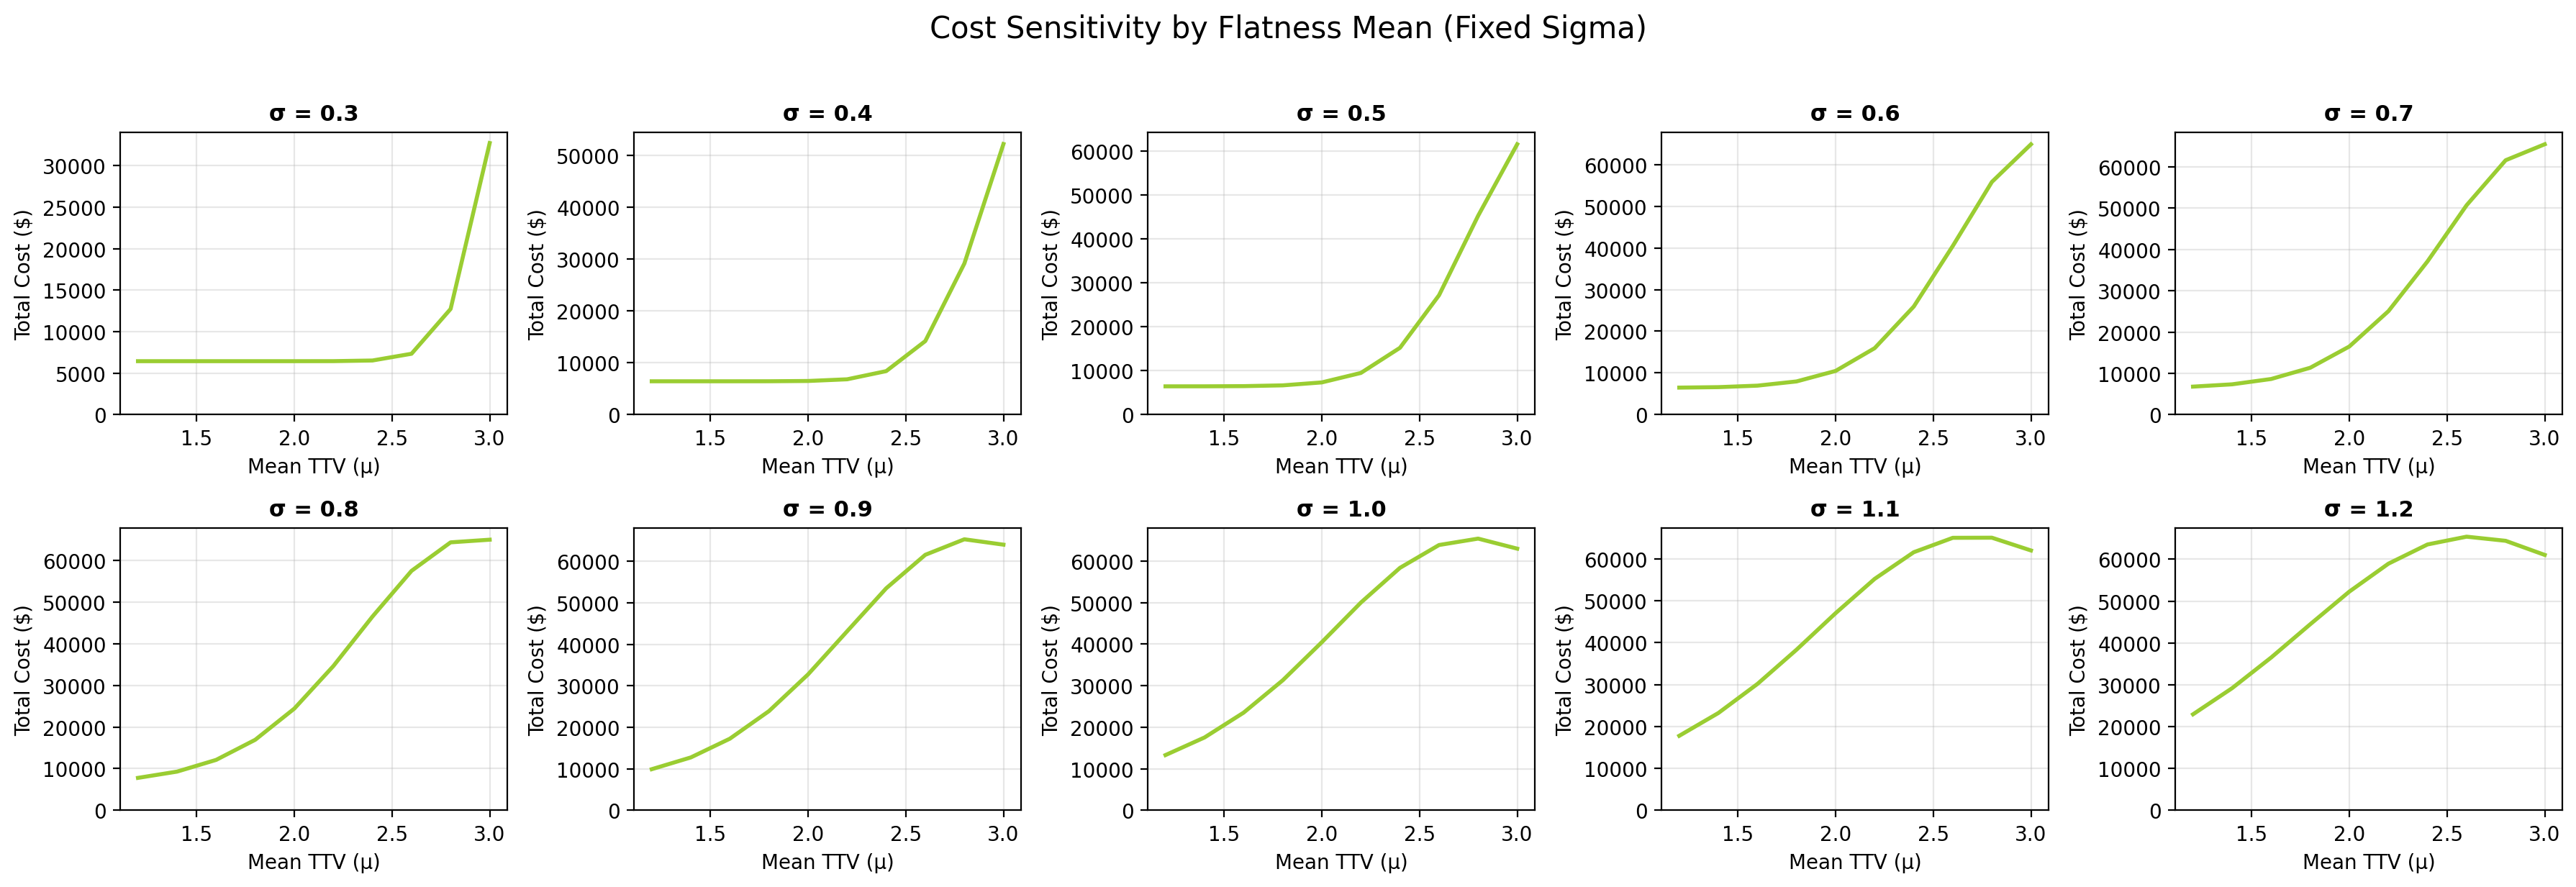

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, binom, norm
from mpl_toolkits.mplot3d import Axes3D

# ==========================================
# 1. 기본 파라미터 (결함 밀도 고정, 평탄도 가변)
# ==========================================
# [공통]
A = 706.9
lot_size = 25
n_sample = 5

# [결함 고정 파라미터]
LAMBDA_FIXED = 0.035
ALPHA_FIXED = 4.2
CUTOFF = 71

# [검사 장비]
alpha_test = 0.01
beta_test = 0.02

# [비용 단가]
C_opportunity = 2500
C_scrap = 900
C_bad_ship = 17100
C_inspect = 30
USL_FLAT = 3.5

# ==========================================
# 2. 비용 계산 함수 정의
# ==========================================
def calculate_cost_flatness(mu_f, sigma_f):
    # 1) 결함 불량 확률 (Negative Binomial) - 고정값
    mu_val = LAMBDA_FIXED * A
    p_nb = ALPHA_FIXED / (ALPHA_FIXED + mu_val)
    p_defect = 1 - nbinom.cdf(CUTOFF - 1, ALPHA_FIXED, p_nb)

    # 2) 평탄도 불량 확률 (Normal) - 가변
    p_flat = 1 - norm.cdf(USL_FLAT, loc=mu_f, scale=sigma_f)

    # 3) 통합 불량 확률
    p_total = 1 - (1 - p_defect) * (1 - p_flat)

    # 4) 검사 판정 (AQL)
    p_prime = (1 - p_total) * alpha_test + p_total * (1 - beta_test)
    P_accept = binom.cdf(0, n_sample, p_prime)
    P_reject = 1 - P_accept

    # 5) 비용 계산 (현실적 일반화 모델)
    cost = (
        P_reject * (1 - p_total) * lot_size * C_opportunity +
        P_reject * p_total * lot_size * C_scrap +
        P_accept * (p_total * lot_size) * C_bad_ship +
        n_sample * C_inspect
    )
    return cost

# ==========================================
# 3. 데이터 생성
# ==========================================
# 평균(Mean): 1.2 ~ 3.0 (10개 포인트)
mu_grid = np.linspace(1.2, 3.0, 10) # X축용

# 산포(Sigma): 0.3 ~ 1.2 (10개 포인트)
sigma_grid = np.linspace(0.3, 1.2, 10) # 서브플롯용 고정값

# 3D Plot용 Meshgrid
M, S = np.meshgrid(mu_grid, sigma_grid)
Cost_surface = np.zeros_like(M)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Cost_surface[i, j] = calculate_cost_flatness(M[i, j], S[i, j])

# ==========================================
# 4. (A) Sigma 고정 → Mean 변화에 따른 비용 민감도 (1D Subplots)
# ==========================================
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
axes = axes.flatten()

for i, sigma in enumerate(sigma_grid):
    costs = [calculate_cost_flatness(mu, sigma) for mu in mu_grid]

    axes[i].plot(mu_grid, costs, color='yellowgreen', linewidth=2)
    axes[i].set_title(f"σ = {sigma:.1f}", fontsize=11, fontweight='bold')
    axes[i].set_xlabel("Mean TTV (μ)")
    axes[i].set_ylabel("Total Cost ($)")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(bottom=0)

plt.suptitle(f"Cost Sensitivity by Flatness Mean (Fixed Sigma)", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

### 해석

### **평탄도(Flatness) 비용 민감도 분석: 평균($\mu$)과 산포($\sigma$)의 영향**

이 분석은 결함 밀도($\lambda=0.035, \alpha=4.2$)가 고정된 상태에서, 평탄도(TTV)의 두 가지 핵심 모수인 **평균($\mu$)**과 **표준편차($\sigma$)**가 변동할 때 로트당 총 품질 비용이 어떻게 반응하는지를 시각화한 것입니다. (규격 상한 USL = 3.5)

---

## **1️⃣ 평균($\mu$) 고정, 산포($\sigma$) 변화에 따른 비용 민감도 (하늘색 그래프)**

이 그래프는 **평균 TTV($\mu$)** 수준별로 공정 산포($\sigma$)가 커질 때 비용이 어떻게 증가하는지를 보여줍니다.

### **주요 패턴 해석**

| 구간 (Mean Level) | 그래프 형태 | 해석 |
| :--- | :--- | :--- |
| **$\mu = 1.20 \sim 1.60$ (안전 구간)** | **J자형 곡선** | 평균이 USL(3.5)에서 멀리 떨어져 있어, $\sigma$가 0.8 수준까지 커져도 비용 증가가 미미합니다. 그러나 $\sigma > 1.0$을 넘어서면 꼬리 부분(Tail)이 규격을 벗어나며 비용이 급증하기 시작합니다. |
| **$\mu = 1.80 \sim 2.20$ (민감 구간)** | **S자형 상승** | 평균이 규격에 가까워지면서 작은 산포 변화에도 민감하게 반응합니다. $\sigma=0.6$ 부근부터 비용이 눈에 띄게 상승하며, 공정 산포 관리가 중요해지는 구간입니다. |
| **$\mu = 2.40 \sim 3.00$ (위험 구간)** | **가파른 초기 상승** | 평균 자체가 위험 수준이므로, 아주 작은 산포($\sigma=0.4$)만 있어도 비용이 폭발적으로 증가합니다. $\mu=3.0$에서는 이미 시작점부터 고비용 구조이며, 산포가 조금만 커져도 비용이 상한선(Plateau)에 도달합니다. |

> **💡 Insight:** 평균이 좋을 때(1.6 이하)는 산포 관리가 다소 느슨해도 비용 방어가 가능하지만, 평균이 나빠지면 산포를 극한으로 통제해야만 생존할 수 있습니다.

---

## **2️⃣ 산포($\sigma$) 고정, 평균($\mu$) 변화에 따른 비용 민감도 (연두색 그래프)**

이 그래프는 **공정 산포($\sigma$)** 수준별로 평균 TTV($\mu$)가 악화(증가)될 때 비용 절벽이 언제 발생하는지를 보여줍니다.

### **주요 패턴 해석**

| 구간 (Sigma Level) | 그래프 형태 | 해석 |
| :--- | :--- | :--- |
| **$\sigma = 0.3 \sim 0.5$ (정밀 공정)** | **L자형 (급격한 절벽)** | 산포가 작을 때는 평균이 2.5까지 나빠져도 불량이 거의 없습니다(비용 바닥 유지). 그러나 임계점($\mu \approx 2.7$)을 넘는 순간, 전체 분포가 USL을 통째로 넘어가며 비용이 수직 상승합니다. **"평균 마진(Margin)"이 큽니다.** |
| **$\sigma = 0.6 \sim 0.9$ (일반 공정)** | **완만한 상승 곡선** | 산포가 커지면서 꼬리 불량이 먼저 발생하므로, 비용 상승 시작점이 $\mu=2.0$ 부근으로 앞당겨집니다. 기울기가 완만해지며 점진적으로 비용이 악화됩니다. |
| **$\sigma = 1.0 \sim 1.2$ (불량 공정)** | **선형/초기 급등** | 산포가 너무 커서 평균이 아무리 좋아도(1.2) 이미 비용이 높습니다. 평균이 조금만 나빠져도 비용이 즉각적으로 반응하여 상승합니다. |

> **💡 Insight:** 산포가 작으면(정밀 공정) 평균이 다소 흔들려도 비용이 버텨주는 **'내성(Tolerance)'**이 생깁니다. 반면 산포가 크면 평균 관리에 대한 여유가 전혀 없습니다.

---

## **✅ 종합 결론**

1.  **우선순위:** 현재 수준($\mu \approx 2.11$)은 **민감 구간**에 위치해 있습니다. 여기서 비용을 획기적으로 줄이려면 **평균($\mu$)을 1.6 이하로 낮추는 Shift Left 전략**이 가장 효과적입니다.
2.  **리스크 관리:** 만약 평균 개선이 어렵다면, **산포($\sigma$)를 0.5 이하로 억제**해야만 비용 폭등을 막을 수 있습니다.
3.  **전략적 선택:**
    * **Best:** 평균 개선 ($\mu \to 1.2$)
    * **Next Best:** 산포 개선 ($\sigma \to 0.4$)
    * **Worst:** 현상 유지 (작은 변동에도 비용 급등 위험)

## 평탄도 3D plot

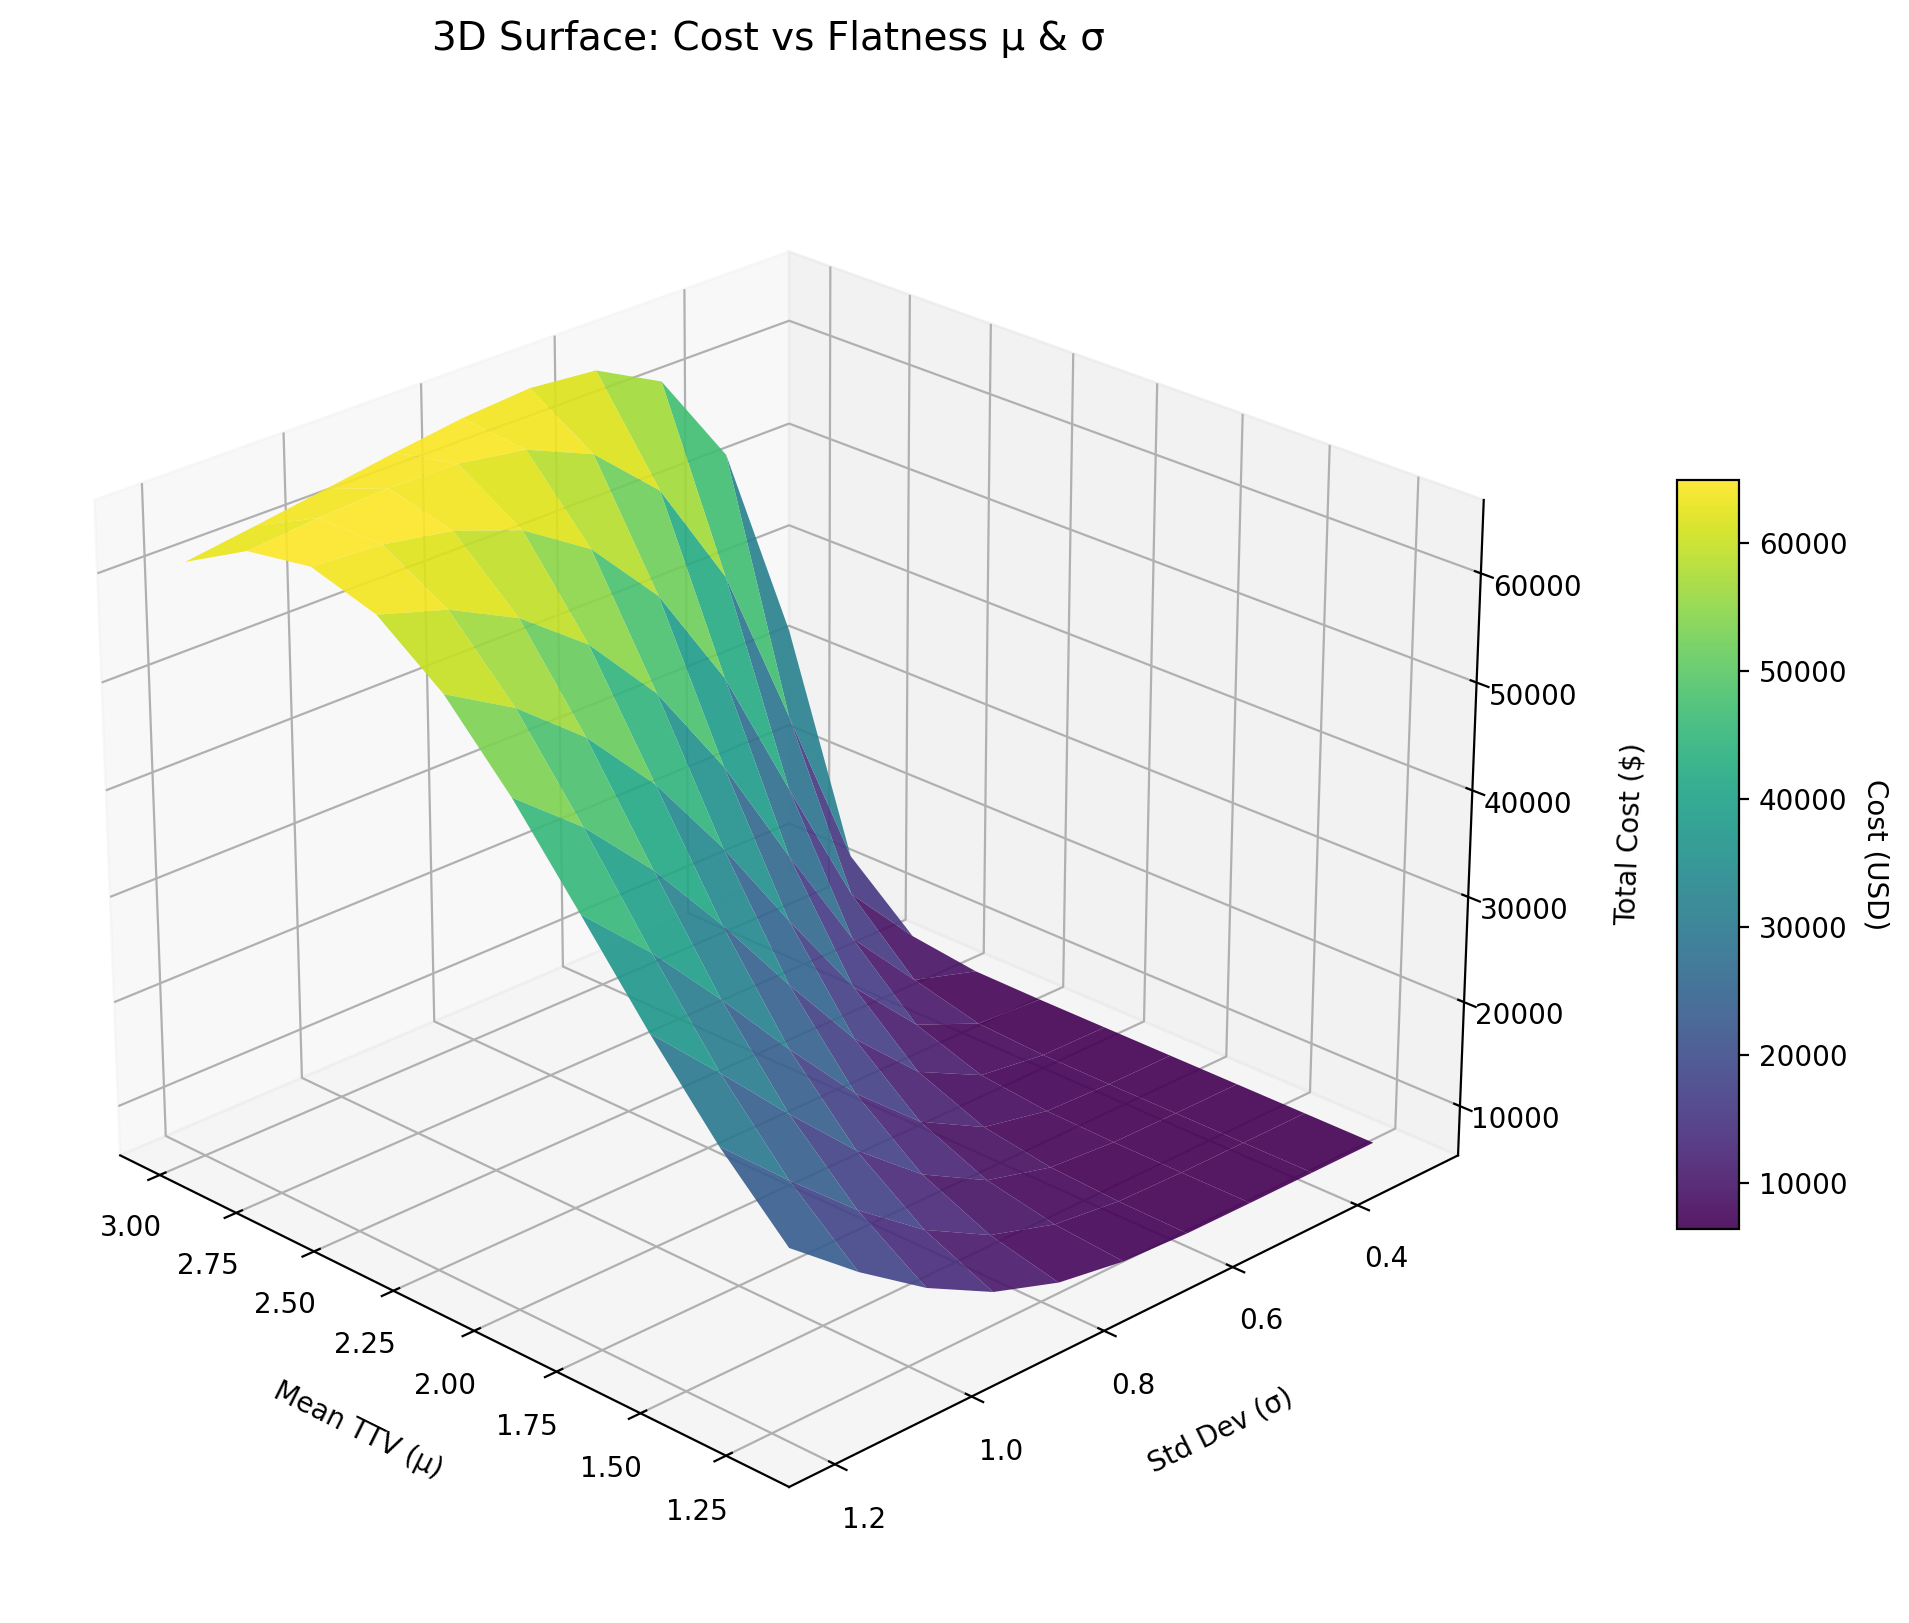

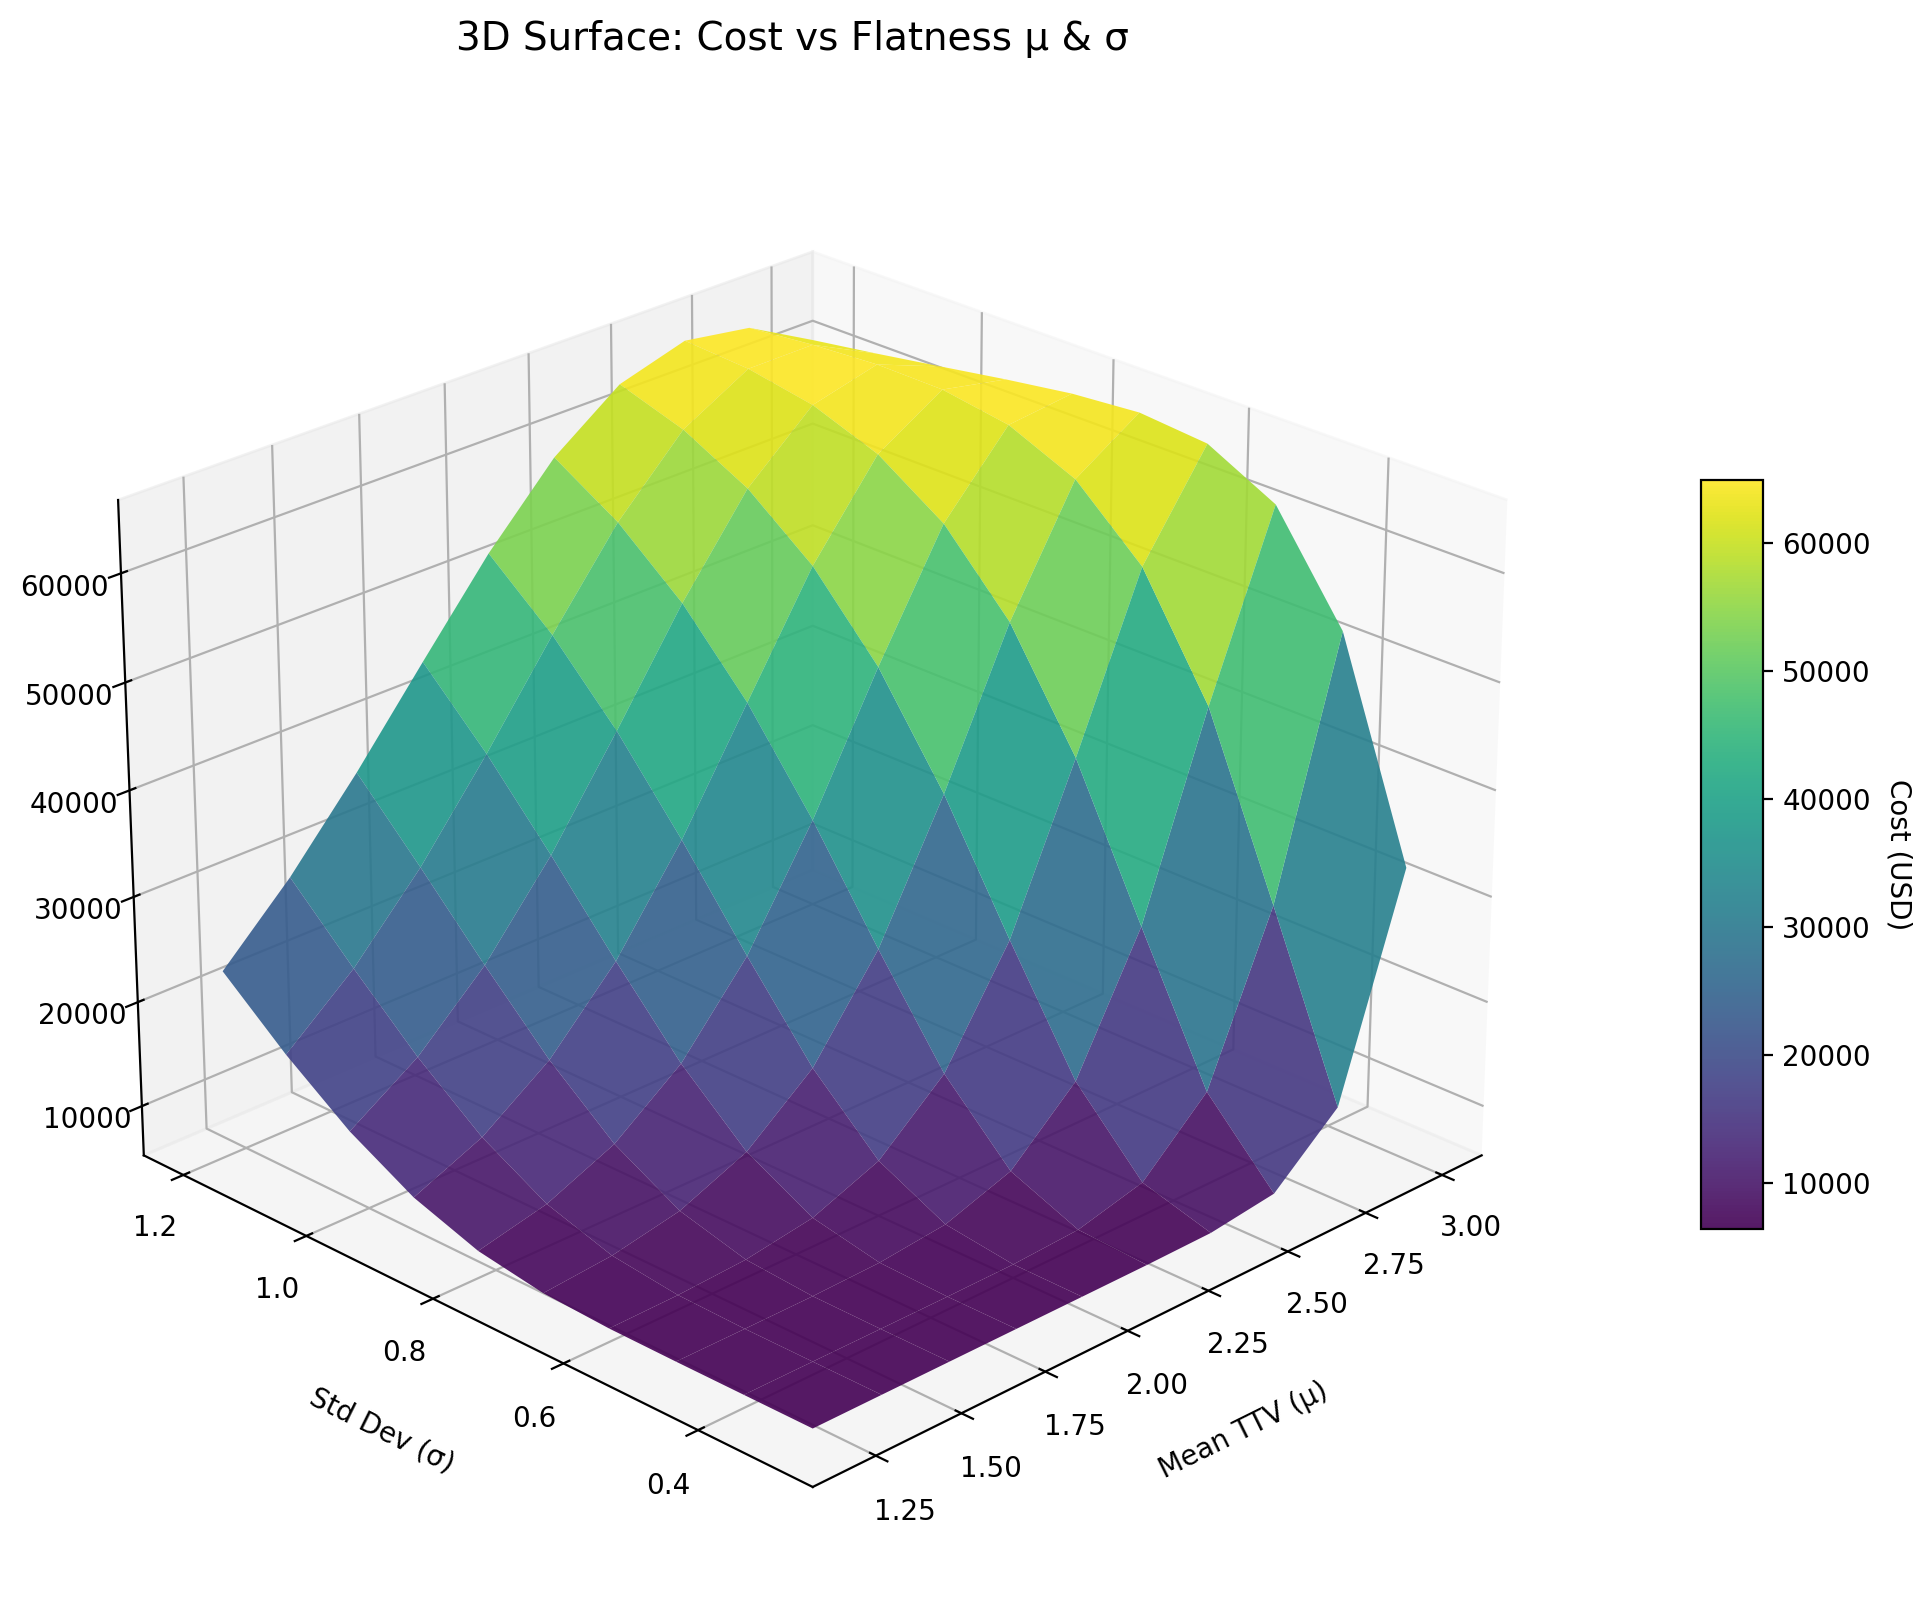

In [ ]:

# ==========================================
# 5. (B) 3D Surface Plot - 각도 1 (기본)
# ==========================================
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(M, S, Cost_surface, cmap='viridis', edgecolor='none', alpha=0.9, antialiased=True)

ax.set_title("3D Surface: Cost vs Flatness μ & σ", fontsize=14, pad=20)
ax.set_xlabel("Mean TTV (μ)", labelpad=12)
ax.set_ylabel("Std Dev (σ)", labelpad=12)
ax.set_zlabel("Total Cost ($)", labelpad=12)

cbar = fig.colorbar(surf, shrink=0.5, aspect=12, pad=0.1)
cbar.set_label("Cost (USD)", rotation=270, labelpad=15)

ax.view_init(elev=25, azim=135) # 각도 1
plt.show()

# ==========================================
# 6. (C) 3D Surface Plot - 각도 2 (회전)
# ==========================================
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(M, S, Cost_surface, cmap='viridis', edgecolor='none', alpha=0.9, antialiased=True)

ax.set_title("3D Surface: Cost vs Flatness μ & σ", fontsize=14, pad=20)
ax.set_xlabel("Mean TTV (μ)", labelpad=12)
ax.set_ylabel("Std Dev (σ)", labelpad=12)
ax.set_zlabel("Total Cost ($)", labelpad=12)

cbar = fig.colorbar(surf, shrink=0.5, aspect=12, pad=0.1)
cbar.set_label("Cost (USD)", rotation=270, labelpad=15)

ax.view_init(elev=25, azim=225) # 각도 2 (90도 회전)
plt.show()


# **품질 특성(결함·평탄도) 기반 단가 조정 논리: 기대 품질비용 활용**

본 모델은 공급사의 **결함 특성($\lambda, \alpha$)** 및 **평탄도 특성($\mu, \sigma$)** 변화가 로트당 기대 품질비용($E[\text{Cost}]$)에 미치는 영향을 통합적으로 정량화하여, 이를 구매 협상 시 단가 조정 ($\Delta\text{Price}\%$)의 객관적 근거로 활용하는 방법입니다.

-----

### **1. 기본 논리 구조**

1.  **기준 정의:** **기준 공정**의 4대 파라미터를 설정하고, 이에 따른 기준 기대 품질비용 $E[\text{Cost}_0]$을 계산합니다.
      * 결함 특성: $\lambda_0=0.035$ (결함 밀도), $\alpha_0=4.2$ (클러스터링)
      * 평탄도 특성: $\mu_0=2.11$ (평균 TTV), $\sigma_0=0.78$ (표준편차)
2.  **공급사 평가:** \*\*공급사 $i$\*\*의 실제 품질 특성($\lambda_i, \alpha_i, \mu_i, \sigma_i$)을 대입하여 해당 공급사의 기대 품질비용 $E[\text{Cost}_i]$를 산출합니다.
3.  **차이 환산:** 기준 대비 비용 절감(또는 증가)분을 **단가 조정율**로 변환하여, 품질 개선에 대한 인센티브나 품질 악화에 대한 페널티를 정량화합니다.

-----

### **2. 품질 단가 조정율 ($\Delta\text{Price}\%$) 수식**

공급사 $i$의 품질(결함 및 평탄도) 변화가 구매자의 리스크 비용에 미치는 증감분을 단가에 반영합니다.

$$\Delta\text{Price}\% = -k \times \frac{E[\text{Cost}_i] - E[\text{Cost}_0]}{E[\text{Cost}_0]} \times 100$$

| 변수 | 설명 | 적용 포인트 |
| :--- | :--- | :--- |
| $\Delta\text{Price}\%$ | **최종 단가 조정율** | 양수(+): 단가 인상 (인센티브)<br>음수(-): 단가 감액 (페널티) |
| $E[\text{Cost}_i]$ | \*\*공급사 $i$\*\*의 기대 비용 | $f(\lambda_i, \alpha_i, \mu_i, \sigma_i)$ 함수로 도출된 총 비용 |
| $E[\text{Cost}_0]$ | **기준 공정**의 기대 비용 | 현재 관리 수준의 기준 비용 |
| $k$ | **협상 탄력 계수** ($0 \le k \le 1$) | 비용 차액을 단가에 반영하는 비율 (시장 지배력 고려) |

-----

### **3. 실무적 해석 및 적용**

평탄도($\mu, \sigma$)가 추가됨에 따라 품질 비용의 변동 폭이 커졌으므로, 이를 반영한 협상 전략이 필요합니다.

| $E[\text{Cost}]$ 비교 | 품질 상태 해석 | 단가 조정 방향 ($\Delta\text{Price}\%$) | 협상 논리 (예시) |
| :--- | :--- | :--- | :--- |
| $E[\text{Cost}_i] < E[\text{Cost}_0]$ | **우수 (Risk 감소)**<br>$\mu \downarrow, \sigma \downarrow$ 또는 $\lambda \downarrow$ | **단가 인상** (양수 +) | "평탄도 개선($\mu 2.1 \to 1.6$)으로 불량 출하 리스크가 30% 감소했으니, 단가를 인상해 드리겠습니다." |
| $E[\text{Cost}_i] > E[\text{Cost}_0]$ | **열위 (Risk 증가)**<br>$\mu \uparrow, \sigma \uparrow$ 또는 $\lambda \uparrow$ | **단가 감액** (음수 $-$) | "공정 산포($\sigma$) 증가로 인해 우리 측 폐기/선별 비용이 급증했습니다. 이에 상응하는 단가 인하를 요구합니다." |

## K 설정 논리

***

## **협상 탄력 계수 ($k$) 설정 전략: Bare Wafer 시장 중심**

**협상 탄력 계수 ($k$)**는 품질비용 차이($\Delta E[\text{Cost}]$)를 실제 단가 조정에 얼마나 반영할지 결정하는 **정책적 선택 변수**입니다. $k$ 값은 공급사의 시장 지위, 협상력, 전략적 중요도 등 **구매 환경**을 반영하여 설정해야 합니다.

---

### **1. $k$의 개념 및 단가 조정 수식**

$k$는 구매처와 공급사 간의 리스크 분담 비율을 나타냅니다.



| $k$ 값 | 정책적 의미 | 리스크 분담 구조 |
| :--- | :--- | :--- |
| **$k = 1.0$** | 비용 차이 100% 반영 | 리스크를 공급사와 구매처가 **완전히 공유**. |
| **$0 < k < 1.0$** | 비용 차이 부분 반영 | 리스크를 **분담** (가장 일반적인 전략). |
| **$k = 0$** | 반영하지 않음 | 비용 차이가 있어도 **단가 변동 없음**. |

---

### **2. Bare Wafer 시장 특성 및 $k$ 설정 기준**

Bare Wafer 시장은 **극도의 시장 집중도(올리고폴리)**와 **높은 진입 장벽**으로 인해 **공급사의 협상력이 매우 강력**합니다. 따라서 $\Delta\text{Cost}$를 $100\%$ 반영하기 어려우며, $k$는 일반적으로 **보수적인 범위($0.3 \sim 0.6$)**에서 설정됩니다.

| 기준 | $k$가 높아지는 경우 (구매처 주도) | $k$가 낮아지는 경우 (공급사 주도) |
| :--- | :--- | :--- |
| **협상력** | 구매처의 대체 가능성이 높음. | **공급사의 시장 지배력 강함** (Wafer 시장 특성). |
| **품질 기여도** | 공급사가 공정 품질 향상에 적극 기여. | 최소 수준의 품질 요구만 충족. |
| **리스크 분담** | 공급사가 품질 리스크를 대부분 부담. | **구매자가 리스크를 대부분 부담** (안정성 중시). |
| **파트너십** | 지역 특화 또는 일반 공급사. | **전략적 Tier 1 공급사** (장기 안정성 중시). |

---

### **3. 전략적 $k$ 값 가이드라인 (Bare Wafer)**

메이저 반도체 기업은 장기 안정성과 기술 협력을 위해 공급사 유형별로 $k$를 차등 적용해야 합니다.

| 공급사 유형 | 시장 지위 | 권장 $k$ 값 범위 | 주요 전략 |
| :--- | :--- | :--- | :--- |
| **Tier 1 전략적 파트너**  | 압도적 강자, 대체 불가 | **$0.3 \sim 0.5$ (보수적)** | 품질비용 반영 최소화. **장기 안정성 및 기술 협력 인센티브**에 중점. |
| **Tier 2 주요 공급사** | 강한 협상력, 제한적 대체 | **$0.4 \sim 0.6$ (균형적)** | 품질 개선 인센티브와 리스크 분담의 균형점 설정. |
| **Tier 3 지역/특화 공급사**  | 상대적 균형, 지역 경쟁 | **$0.5 \sim 0.7$ (적극적)** | 품질비용 반영을 상대적으로 높여 품질 개선 유도. |
| **첨단 웨이퍼** (예: 300mm) | 공급사 선택권 극히 제한 | **$0.2 \sim 0.4$** | 공급 안정이 최우선이므로 $k$를 낮게 설정. |

---

**결론:** $k$는 **수학적 산출 값이 아닌 정책적 파라미터**이며, **시장 상황(공급자 우위)과 공급사와의 전략적 관계**를 고려하여 $0.3 \sim 0.7$ 범위 내에서 유연하게 설정하는 것이 가장 효과적입니다.
```

## 단가 히트맵

### 2D
* Scenario A: 결함 집중 분석 (Defect Focus)축: X축 $\lambda$, Y축 $\alpha$고정: 평탄도는 기준값($\mu_0=2.11, \sigma_0=0.78$)으로 고정.
  * 의미: "평탄도는 그대로인데, 공급사의 결함 관리 능력이 변할 때 단가를 어떻게 조정할까?"

* Scenario B: 평탄도 집중 분석 (Flatness Focus)축: X축 $\mu$ (Mean), Y축 $\sigma$ (Sigma)고정: 결함은 기준값($\lambda_0=0.035, \alpha_0=4.2$)으로 고정.

  * 의미: "결함 수준은 유지하는데, 평탄도 스펙을 타이트하게($\mu \downarrow$) 요구하면 단가를 얼마나 올려줘야 할까?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, binom, norm
import ipywidgets as widgets
from ipywidgets import interact

# ==========================================
# 0. 파라미터 및 비용 함수 (General Model)
# ==========================================
# [기준 파라미터]
LAMBDA_REF = 0.035
ALPHA_REF = 4.2
MU_REF = 2.11004
SIGMA_REF = 0.78286

# [공통 상수]
A = 706.9
CUTOFF = 71
USL_FLAT = 3.5
lot_size = 25
n_sample = 5
alpha_test = 0.01
beta_test = 0.02

COSTS = {'opp': 2500, 'scrap': 900, 'escape': 17100, 'inspect': 30}

def calculate_total_cost(lambda_d, alpha_d, mu_f, sigma_f):
    """4개 변수를 고려한 로트당 총 품질 비용"""
    # 1. 결함 불량 확률
    mu_val = lambda_d * A
    p_nb = alpha_d / (alpha_d + mu_val)
    p_defect = 1 - nbinom.cdf(CUTOFF - 1, alpha_d, p_nb)

    # 2. 평탄도 불량 확률
    p_flat = 1 - norm.cdf(USL_FLAT, loc=mu_f, scale=sigma_f)

    # 3. 통합 불량 확률
    p_total = 1 - (1 - p_defect) * (1 - p_flat)

    # 4. 검사 판정
    p_prime = (1 - p_total) * alpha_test + p_total * (1 - beta_test)
    P_accept = binom.cdf(0, n_sample, p_prime)
    P_reject = 1 - P_accept

    # 5. 비용 계산 (일반화 모델)
    cost = (
        P_reject * (1 - p_total) * lot_size * COSTS['opp'] +
        P_reject * p_total * lot_size * COSTS['scrap'] +
        P_accept * (p_total * lot_size) * COSTS['escape'] +
        n_sample * COSTS['inspect']
    )
    return cost

# 기준 비용
cost_ref = calculate_total_cost(LAMBDA_REF, ALPHA_REF, MU_REF, SIGMA_REF)

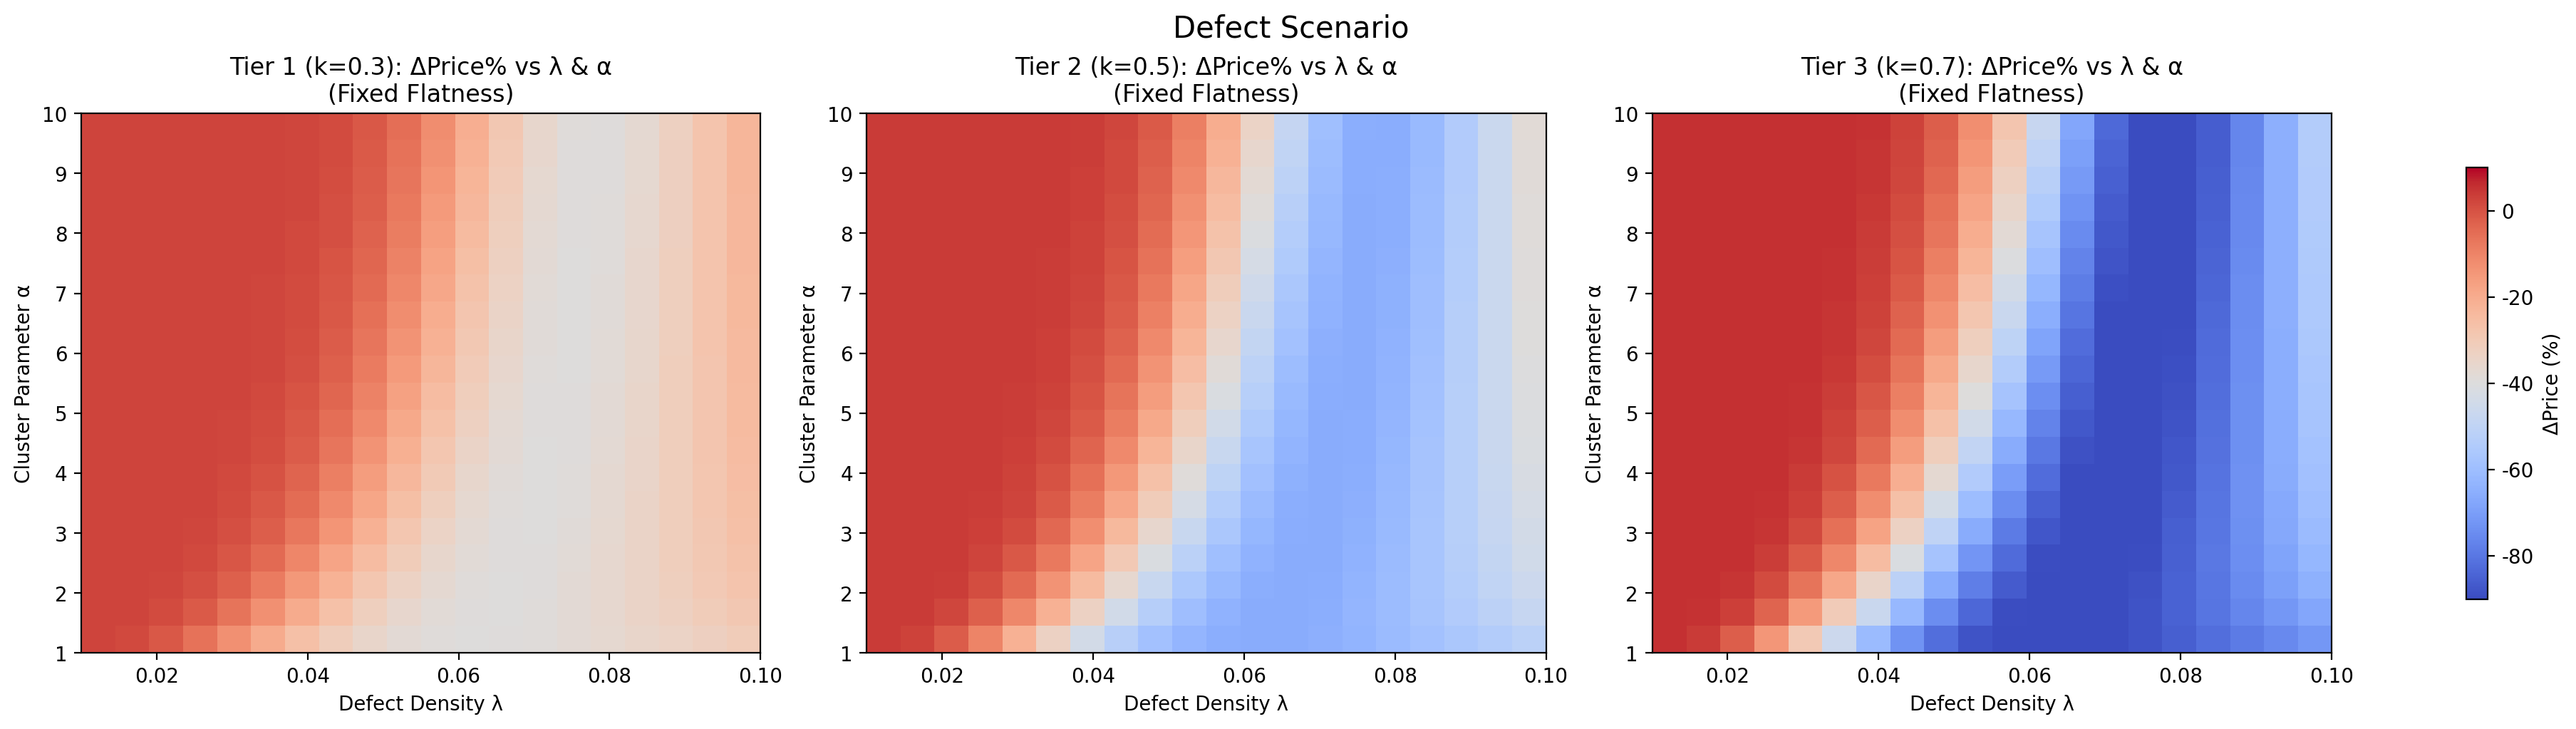

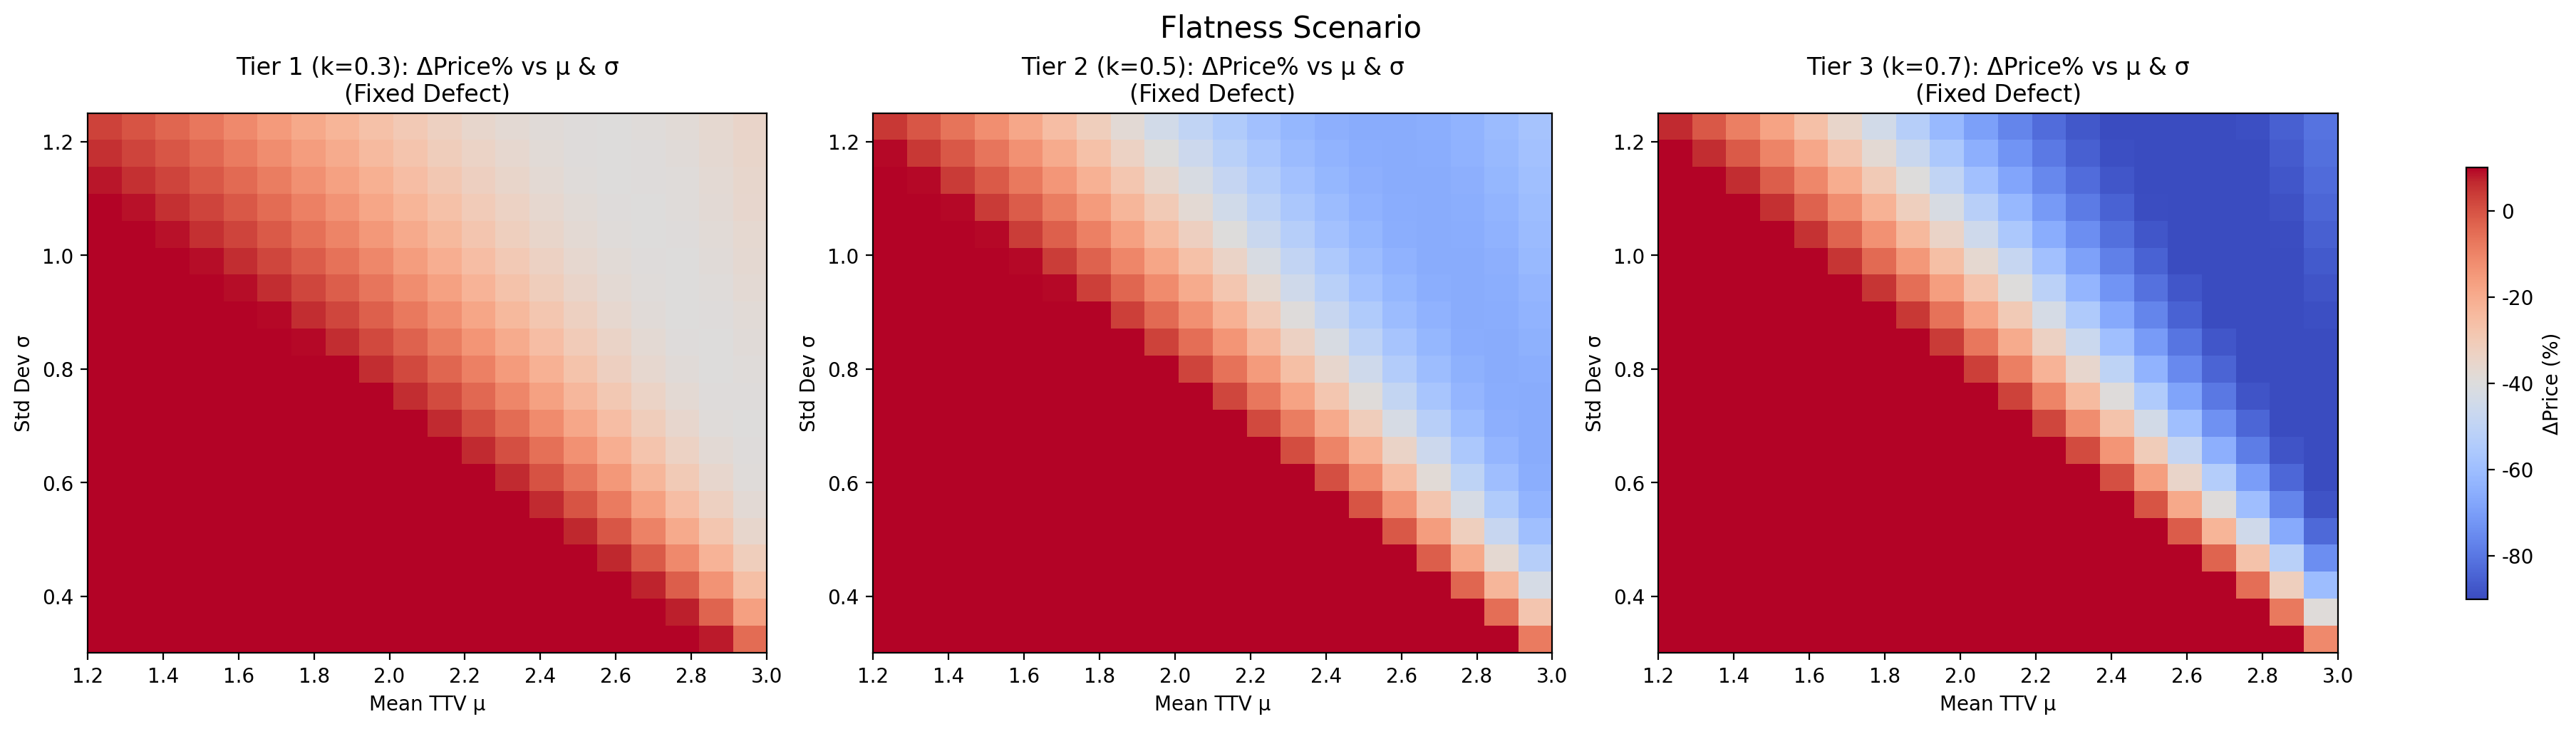

In [ ]:
# ==========================================
# Chart 1-A: 결함 시나리오 (Defect Focus)
# 형식: 제공해주신 코드 스타일 유지
# ==========================================
# 1. 그리드 설정
lambda_grid = np.linspace(0.01, 0.10, 20)
alpha_grid = np.linspace(1, 10, 20)
Lambda, Alpha = np.meshgrid(lambda_grid, alpha_grid)

# 2. ΔPrice% 계산 함수
def calc_price_adj_defect(k_value):
    Delta_surface = np.zeros_like(Lambda)
    for i in range(len(alpha_grid)):
        for j in range(len(lambda_grid)):
            # 평탄도는 기준값 고정
            cost_ij = calculate_total_cost(Lambda[i, j], Alpha[i, j], MU_REF, SIGMA_REF)
            delta_cost = (cost_ij - cost_ref) / cost_ref
            delta_price = -k_value * delta_cost * 100
            Delta_surface[i, j] = delta_price
    return Delta_surface

# 3. Tier별 결과 계산
tiers = {'Tier 1 (k=0.3)': 0.3, 'Tier 2 (k=0.5)': 0.5, 'Tier 3 (k=0.7)': 0.7}
results_defect = {name: calc_price_adj_defect(k) for name, k in tiers.items()}

# 4. 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, (tier_name, delta) in zip(axes, results_defect.items()):
    im = ax.imshow(delta, cmap='coolwarm', origin='lower',
                   extent=[lambda_grid.min(), lambda_grid.max(), alpha_grid.min(), alpha_grid.max()],
                   aspect='auto', vmin=-90, vmax=10)
    ax.set_title(f"{tier_name}: ΔPrice% vs λ & α\n(Fixed Flatness)", fontsize=12)
    ax.set_xlabel("Defect Density λ")
    ax.set_ylabel("Cluster Parameter α")

# 공통 colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label("ΔPrice (%)")
plt.suptitle("Defect Scenario", fontsize=15)
plt.show()


# ==========================================
# Chart 1-B: 평탄도 시나리오 (Flatness Focus)
# 형식: 동일 스타일 적용
# ==========================================
# 1. 그리드 설정
mu_grid = np.linspace(1.2, 3.0, 20)
sigma_grid = np.linspace(0.3, 1.25, 20)
Mu, Sigma = np.meshgrid(mu_grid, sigma_grid)

# 2. ΔPrice% 계산 함수
def calc_price_adj_flatness(k_value):
    Delta_surface = np.zeros_like(Mu)
    for i in range(len(sigma_grid)):
        for j in range(len(mu_grid)):
            # 결함은 기준값 고정
            cost_ij = calculate_total_cost(LAMBDA_REF, ALPHA_REF, Mu[i, j], Sigma[i, j])
            delta_cost = (cost_ij - cost_ref) / cost_ref
            delta_price = -k_value * delta_cost * 100
            Delta_surface[i, j] = delta_price
    return Delta_surface

# 3. Tier별 결과 계산
results_flatness = {name: calc_price_adj_flatness(k) for name, k in tiers.items()}

# 4. 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, (tier_name, delta) in zip(axes, results_flatness.items()):
    im = ax.imshow(delta, cmap='coolwarm', origin='lower',
                   extent=[mu_grid.min(), mu_grid.max(), sigma_grid.min(), sigma_grid.max()],
                   aspect='auto', vmin=-90, vmax=10)
    ax.set_title(f"{tier_name}: ΔPrice% vs μ & σ\n(Fixed Defect)", fontsize=12)
    ax.set_xlabel("Mean TTV μ")
    ax.set_ylabel("Std Dev σ")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label("ΔPrice (%)")
plt.suptitle("Flatness Scenario", fontsize=15)
plt.show()

### 4D

In [ ]:
# ==========================================
# 2. 4D Interactive Visualization (Rotated View)
# ==========================================
# X축: Defect Density (λ), Y축: Mean TTV (μ)
# Z축: Price Adjustment (%)
# 슬라이더 조절 변수: Cluster(α), Sigma(σ), 협상계수(k)

def plot_4d_interactive(alpha_val, sigma_val, k_val):
    # 데이터 그리드 (해상도 조정)
    l_grid = np.linspace(0.01, 0.10, 25)
    m_grid = np.linspace(1.2, 3.0, 25)
    L, M = np.meshgrid(l_grid, m_grid)

    Z = np.zeros_like(L)

    # 그리드별 계산 (α와 σ는 슬라이더 값 사용)
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            cost = calculate_total_cost(L[i,j], alpha_val, M[i,j], sigma_val)
            # 단가 조정률 계산
            Z[i,j] = -k_val * ((cost - cost_ref) / cost_ref) * 100

    # 3D Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(L, M, Z, cmap='coolwarm', edgecolor='none', alpha=0.85, vmin=-100, vmax=20)

    # 기준점 표시 (Baseline)
    # 현재 슬라이더가 Baseline과 일치할 때만 별표 표시
    if np.isclose(alpha_val, ALPHA_REF, atol=0.5) and np.isclose(sigma_val, SIGMA_REF, atol=0.1):
        base_z = 0 # Baseline은 조정률 0%
        ax.scatter(LAMBDA_REF, MU_REF, base_z, color='yellow', s=200, marker='*', edgecolors='black', label='Baseline', zorder=10)
        ax.legend()

    ax.set_xlabel('Defect Density λ')
    ax.set_ylabel('Mean TTV μ')
    ax.set_zlabel('ΔPrice (%)')
    ax.set_title(f'4D Analysis: Price Sensitivity\n(α={alpha_val:.1f}, σ={sigma_val:.2f})', fontsize=14)
    ax.set_zlim(-100, 20) # Z축 고정하여 변화 비교 용이하게 함

    # 🔹 시각 각도 수정 (135 -> 225: 왼쪽으로 90도 회전)
    ax.view_init(elev=25, azim=315)

    fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.1, label='Price Adj (%)')
    plt.show()

# 인터랙티브 위젯 생성
print("⬇️ 아래 슬라이더를 움직여 α(공정균질도)와 σ(산포)의 변화가 단가에 미치는 영향을 확인하세요.")
interact(plot_4d_interactive,
         alpha_val=widgets.FloatSlider(min=1.0, max=10.0, step=0.5, value=4.2, description='Cluster α'),
         sigma_val=widgets.FloatSlider(min=0.3, max=1.25, step=0.05, value=0.78, description='Sigma σ'),
         k_val=widgets.FloatSlider(min=0.1, max=1.0, step=0.1, value=0.5, description='Neg. Factor k'));

⬇️ 아래 슬라이더를 움직여 α(공정균질도)와 σ(산포)의 변화가 단가에 미치는 영향을 확인하세요.


interactive(children=(FloatSlider(value=4.2, description='Cluster α', max=10.0, min=1.0, step=0.5), FloatSlide…

## 단가 히트맵 해석

## 1. 개요

히트맵은 공급사의 품질 수준 변화(결함·평탄도)가 구매 단가에 미치는 영향을 시뮬레이션한 결과이다.
두 시나리오(Defect vs Flatness)는 전혀 다른 민감도 패턴을 보이며, 이에 따라 **협상 방식 또한 달라져야 한다.**

---

# 2. Defect 시나리오: “기준 준수 중심의 구조”

### A. 핵심 해석

1. **λ(결함 밀도)가 단가의 주요 결정 요인**

   * 색상 변화가 거의 λ 축을 따라 수직 방향으로 나타남.
   * λ가 0.035~0.04를 넘어서면 α(균질도)의 개선만으로는 단가 방어가 어려움.
   * 즉, 결함 품질은 “절대 기준”에 가까움.

2. **α(균질도)는 보조적 변수**

   * 동일 λ 구간에서 α가 높을수록 페널티 강도가 완화됨.
   * 단가 인상/감액을 결정하는 요인이 아니라, “감액 폭을 줄이는 역할”에 가깝다.

### B. 시사점

* 결함 시나리오는 **기준 충족 여부가 우선**이며,
  λ 개선이 없으면 인센티브 제공이 어려움.
* 공급사와의 논의는 “기준치 준수 → 인상/감액 자동 반영” 방식이 적합하다.

---

# 3. Flatness 시나리오: “대체·보완의 가능성이 존재하는 구조”

### A. 핵심 해석

1. **μ(평균)–σ(산포) 간 명확한 보완 관계**

   * 히트맵의 경계선이 우하향 대각선 형태로 나타남.
   * μ가 다소 높더라도, σ를 낮추면 비용이 개선되는 구조.
   * 반대로 σ가 다소 크더라도, μ를 충분히 낮추면 리스크가 줄어든다.

2. **넓은 인센티브 가능 영역**

   * 현재 기준점(μ≈2.11, σ≈0.78)이 민감도 높은 경계 영역에 위치.
   * 공급사는 두 변수 중 하나만 개선해도 단가 인상 효과가 발생한다.

### B. 시사점

* Flatness는 **Trade-off 기반 협상**이 가능하다.
* 공급사에게 “μ 또는 σ 중 선택적 개선” 옵션을 제시하는 방식이 효율적이다.

  * μ 개선 중심 전략
  * σ 안정화 전략 (균일도 확보)
* 기술 협력·공정 안정화 논의가 Defect보다 더 효과적이다.

---

# 4. 종합 비교

| 항목      | Defect Scenario (결함)    | Flatness Scenario (평탄도) |
| ------- | ----------------------- | ----------------------- |
| 주요 패턴   | λ 중심의 수직 변화             | μ–σ 간 보완적 변화            |
| 민감도 성격  | 절대 기준 (Hard Constraint) | 상쇄 가능 (Trade-off)       |
| 협상 방식   | 기준 충족 여부에 따른 기계적 조정     | 공급사 역량 기반의 선택적 개선 제안    |
| Tier 영향 | Tier 3에 페널티 민감          | Tier 1은 기술 협업 효과 큼      |

---

# **5. 결론**

* **결함(λ)**: 기준 중심의 관리가 필요하며, λ 개선 여부를 중심으로 단가를 조정하는 것이 타당하다.
* **평탄도(μ, σ)**: 두 변수가 상호 보완적이므로, 공급사마다 개선 가능 영역을 선택하게 하는 **유연한 협상 구조**가 효과적이다.

---


## 단가표

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import nbinom, binom, norm
from google.colab import files # 코랩 다운로드용

# ==========================================
# 1. 기본 파라미터 및 비용 함수
# ==========================================
LAMBDA_REF = 0.035
ALPHA_REF = 4.2
MU_REF = 2.11004
SIGMA_REF = 0.78286

A = 706.9
CUTOFF = 71
USL_FLAT = 3.5
lot_size = 25
n_sample = 5
alpha_test = 0.01
beta_test = 0.02
COSTS = {'opp': 2500, 'scrap': 900, 'escape': 17100, 'inspect': 30}

def calculate_total_cost(lambda_d, alpha_d, mu_f, sigma_f):
    mu_val = lambda_d * A
    p_nb = alpha_d / (alpha_d + mu_val)
    p_defect = 1 - nbinom.cdf(CUTOFF - 1, alpha_d, p_nb)
    p_flat = 1 - norm.cdf(USL_FLAT, loc=mu_f, scale=sigma_f)
    p_total = 1 - (1 - p_defect) * (1 - p_flat)

    p_prime = (1 - p_total) * alpha_test + p_total * (1 - beta_test)
    P_accept = binom.cdf(0, n_sample, p_prime)
    P_reject = 1 - P_accept

    cost = (
        P_reject * (1 - p_total) * lot_size * COSTS['opp'] +
        P_reject * p_total * lot_size * COSTS['scrap'] +
        P_accept * (p_total * lot_size) * COSTS['escape'] +
        n_sample * COSTS['inspect']
    )
    return cost

cost_ref = calculate_total_cost(LAMBDA_REF, ALPHA_REF, MU_REF, SIGMA_REF)

# ==========================================
# 2. 그리드 설정 (테이블용)
# ==========================================
# 1) Defect Scenario (λ, α)
lambda_grid = np.linspace(0.01, 0.10, 10) # 열 (Column)
alpha_grid = np.linspace(1, 10, 10)       # 행 (Index)

# 2) Flatness Scenario (μ, σ)
mu_grid = np.linspace(1.2, 3.0, 10)       # 열 (Column)
sigma_grid = np.linspace(0.3, 1.25, 10)   # 행 (Index)

# ==========================================
# 3. 테이블 생성 함수
# ==========================================
def generate_df(k, mode):
    if mode == 'defect':
        # 행: Alpha, 열: Lambda
        data = []
        for a in alpha_grid:
            row = []
            for l in lambda_grid:
                c = calculate_total_cost(l, a, MU_REF, SIGMA_REF)
                delta = -k * ((c - cost_ref) / cost_ref) * 100
                row.append(delta)
            data.append(row)

        df = pd.DataFrame(data,
                          index=[f"α={x:.1f}" for x in alpha_grid],
                          columns=[f"λ={x:.3f}" for x in lambda_grid])
        return df

    elif mode == 'flatness':
        # 행: Sigma, 열: Mean TTV
        data = []
        for s in sigma_grid:
            row = []
            for m in mu_grid:
                c = calculate_total_cost(LAMBDA_REF, ALPHA_REF, m, s)
                delta = -k * ((c - cost_ref) / cost_ref) * 100
                row.append(delta)
            data.append(row)

        df = pd.DataFrame(data,
                          index=[f"σ={x:.2f}" for x in sigma_grid],
                          columns=[f"μ={x:.2f}" for x in mu_grid])
        return df

# ==========================================
# 4. 엑셀 저장 및 출력
# ==========================================
tiers = {'Tier1': 0.3, 'Tier2': 0.5, 'Tier3': 0.7}
file_name = 'Wafer_Price_Adjustment_Tables.xlsx'

print(f"Creating Excel file: {file_name} ...\n")

with pd.ExcelWriter(file_name) as writer:
    for name, k in tiers.items():
        print(f"Processing {name} (k={k})...")

        # 1. Defect Table
        df_defect = generate_df(k, 'defect')
        sheet_name_d = f"{name}_Defect"
        df_defect.to_excel(writer, sheet_name=sheet_name_d)
        print(f"  - Saved: {sheet_name_d}")

        # 콘솔에 Tier 2만 샘플로 출력
        if name == 'Tier2':
            print(f"\n--- [Preview] {name} Defect Table ---")
            print(df_defect.round(2))

        # 2. Flatness Table
        df_flat = generate_df(k, 'flatness')
        sheet_name_f = f"{name}_Flatness"
        df_flat.to_excel(writer, sheet_name=sheet_name_f)
        print(f"  - Saved: {sheet_name_f}")

        if name == 'Tier2':
            print(f"\n--- [Preview] {name} Flatness Table ---")
            print(df_flat.round(2))
            print("-" * 50)

print(f"\n✅ 모든 테이블 생성 완료! 다운로드를 시작합니다.")
files.download(file_name)

Creating Excel file: Wafer_Price_Adjustment_Tables.xlsx ...

Processing Tier1 (k=0.3)...
  - Saved: Tier1_Defect
  - Saved: Tier1_Flatness
Processing Tier2 (k=0.5)...
  - Saved: Tier2_Defect

--- [Preview] Tier2 Defect Table ---
        λ=0.010  λ=0.020  λ=0.030  λ=0.040  λ=0.050  λ=0.060  λ=0.070  \
α=1.0      3.95    -2.52   -23.91   -46.74   -60.80   -65.92   -65.20   
α=2.0      4.02     3.32    -5.73   -27.78   -50.77   -63.75   -65.88   
α=3.0      4.03     3.93     0.55   -14.99   -39.98   -59.65   -66.16   
α=4.0      4.03     4.01     2.71    -7.35   -30.59   -54.65   -65.77   
α=5.0      4.03     4.02     3.50    -2.89   -23.03   -49.42   -64.81   
α=6.0      4.03     4.02     3.80    -0.27   -17.13   -44.32   -63.46   
α=7.0      4.03     4.02     3.92     1.30   -12.58   -39.54   -61.84   
α=8.0      4.03     4.02     3.98     2.26    -9.08   -35.16   -60.04   
α=9.0      4.03     4.03     4.00     2.86    -6.40   -31.22   -58.12   
α=10.0     4.03     4.03     4.01     3.2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>